Bu notebook linear regresyon ailesine ait modellerin performanslarını karşılaştırmak ve bu spesifik görevde ne kadar iyi olduklarını ölçmek için oluşturulmuştur.

# Setup

In [1]:
import os
import json

from sklearn.linear_model import Lasso, Ridge, ElasticNet, HuberRegressor, BayesianRidge, QuantileRegressor, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.svm import SVR

from tqdm import tqdm 

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.dates as mdates

In [2]:
data_seed = 12

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# PHASE 1: Load Data 

In [5]:
df = pd.read_csv(r"DATASETS\ForForecast.csv")
df['TransactionDateTime'] = pd.to_datetime(df['TransactionDateTime'])
df.set_index('TransactionDateTime', inplace=True)
df = df.sort_index()

print(f"Shape {df.shape}")
df.tail(10)

Shape (13499, 19)


ChannelKey  DataAreaKey InventKey InventLocationKey  \
TransactionDateTime                                                        
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   

                    CampaignKrcKey  SalesQuantity  SalesGrossAmount  \
TransactionDateTime                                                   
2024-02-08 22:12:00           6414            4.0            221.01   
2024-02-08 22:12:00           6414            1.0            127.51   
2024-02-08 22:12:00           6414            4.0            221.01   
2024-02-08 22:12:00           6414            1.0            127.52   
2024-02-08 22:12:00           6414            1.0            115.91   
2024-02-08 22:28:00            -99            1.0            110.49   
2024-02-08 22:28:00           6415            3.0            101.99   
2024-02-08 22:28:00              2            1.0            297.49   
2024-02-08 22:28:00            -99            1.0             84.99   
2024-02-08 22:28:00            -99            2.0            305.99   

                     Return_Quantity  NetQuantity  NetGrossAmount  \
TransactionDateTime                                                 
2024-02-08 22:12:00              0.0          4.0          221.01   
2024-02-08 22:12:00              0.0          1.0          127.51   
2024-02-08 22:12:00              0.0          4.0          221.01   
2024-02-08 22:12:00              0.0          1.0          127.52   
2024-02-08 22:12:00              0.0          1.0          115.91   
2024-02-08 22:28:00              0.0          1.0          110.49   
2024-02-08 22:28:00              0.0          3.0          101.99   
2024-02-08 22:28:00              0.0          1.0          297.49   
2024-02-08 22:28:00              0.0          1.0           84.99   
2024-02-08 22:28:00              0.0          2.0          305.99   

                     ReturnGrossAmount  ReturnNetAmount  NetAmountWOVat  \
TransactionDateTime                                                       
2024-02-08 22:12:00                0.0              0.0          184.17   
2024-02-08 22:12:00                0.0              0.0          106.26   
2024-02-08 22:12:00                0.0              0.0          184.17   
2024-02-08 22:12:00                0.0              0.0          106.27   
2024-02-08 22:12:00                0.0              0.0           96.59   
2024-02-08 22:28:00                0.0              0.0           92.07   
2024-02-08 22:28:00                0.0              0.0           84.99   
2024-02-08 22:28:00                0.0              0.0          270.45   
2024-02-08 22:28:00                0.0              0.0           70.83   
2024-02-08 22:28:00                0.0              0.0          254.99   

                     DiscountAmount  DiscountGrossAmount RboStoreKey  \
TransactionDateTime                                                    
2024-02-08 22:12:00          390.71               390.71      others   
2024-02-08 22:12:00          343.07               343.07      others   
2024-02-08 22:12:00          390.71               390.71      others   
2024-02-08 22:12:00          343.06               343.06      others   
2024-02-08 22:12:00          213.49               213.49      others   
2024-02-08 22:28:00  

In [6]:
df.dtypes

ChannelKey               int64
DataAreaKey              int64
InventKey               object
InventLocationKey       object
CampaignKrcKey          object
SalesQuantity          float64
SalesGrossAmount       float64
Return_Quantity        float64
NetQuantity            float64
NetGrossAmount         float64
ReturnGrossAmount      float64
ReturnNetAmount        float64
NetAmountWOVat         float64
DiscountAmount         float64
DiscountGrossAmount    float64
RboStoreKey             object
NetAmount              float64
HourIntervalKey          int64
IsFirstOrder              bool
dtype: object

# PHASE 2: Prepare Data

## Resample and fix

In [7]:
desired_column = 'NetAmountWOVat'

In [8]:
df = df[[desired_column]]

In [9]:
resampled_df = df.resample('60T', closed="left").sum()
resampled_df.shape

(206, 1)

In [10]:
resampled_df.head(10)

NetAmountWOVat
TransactionDateTime                
2024-01-31 09:00:00         7444.94
2024-01-31 10:00:00        16321.85
2024-01-31 11:00:00        16112.86
2024-01-31 12:00:00         9955.61
2024-01-31 13:00:00        36883.48
2024-01-31 14:00:00        11374.87
2024-01-31 15:00:00        49252.87
2024-01-31 16:00:00        65630.39
2024-01-31 17:00:00        31425.66
2024-01-31 18:00:00        39486.80

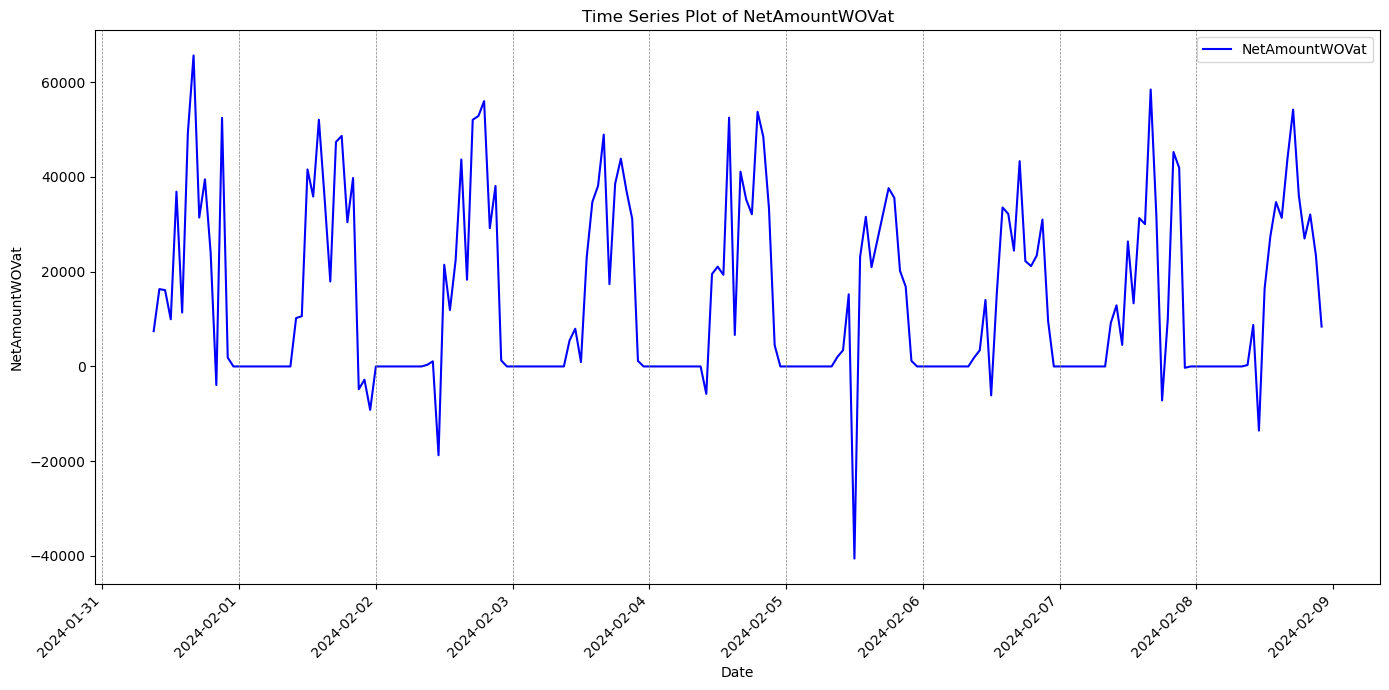

In [11]:
plt.figure(figsize=(14, 7))

plt.plot(resampled_df.index, resampled_df[f'{desired_column}'], label=f'{desired_column}', color='blue')

plt.xlabel('Date')
plt.ylabel(f'{desired_column}')
plt.title(f'Time Series Plot of {desired_column}')

plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45, ha='right')

for date in np.unique(resampled_df.index.date):
    plt.axvline(x=date, color='gray', linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout()  # Ensure proper spacing
plt.show()

In [12]:
Q1 = resampled_df[desired_column].quantile(0.25)
Q3 = resampled_df[desired_column].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1 * IQR
upper_bound = Q3 + 1 * IQR

outliers = resampled_df[(resampled_df[desired_column] < lower_bound) | (resampled_df[desired_column] > upper_bound)]

resampled_df = resampled_df[(resampled_df[desired_column] >= lower_bound) & (resampled_df[desired_column] <= upper_bound)]

print("Number of outliers removed:", len(outliers))
print("DataFrame size after removing outliers:", len(resampled_df))

Number of outliers removed: 2
DataFrame size after removing outliers: 204


In [13]:
"""
Bu notebook'un bir farkı linear modellerin sekans şeklindeki verileri doğal oalrak işleyemediği için bunların suni bir şekilde "önceki 1, önceki 2" gibi
eklenmesi gerektiğidir.
"""

sequence_length = 1

resampled_df["HourInterval"] = resampled_df.index.hour
resampled_df['DayOfWeek'] = resampled_df.index.dayofweek + 1
for i in range(1, sequence_length+1):
    resampled_df[f'{desired_column} Before {i}'] = resampled_df[f'{desired_column}'].shift(i)

resampled_df = resampled_df.dropna()

In [14]:
print(resampled_df.shape)
resampled_df.head()

(203, 4)


NetAmountWOVat  HourInterval  DayOfWeek  \
TransactionDateTime                                            
2024-01-31 10:00:00        16321.85            10          3   
2024-01-31 11:00:00        16112.86            11          3   
2024-01-31 12:00:00         9955.61            12          3   
2024-01-31 13:00:00        36883.48            13          3   
2024-01-31 14:00:00        11374.87            14          3   

                     NetAmountWOVat Before 1  
TransactionDateTime                           
2024-01-31 10:00:00                  7444.94  
2024-01-31 11:00:00                 16321.85  
2024-01-31 12:00:00                 16112.86  
2024-01-31 13:00:00                  9955.61  
2024-01-31 14:00:00                 36883.48

In [15]:
features = ['HourInterval', 'DayOfWeek']
for i in range(1, sequence_length+1):
    features.append( f'{desired_column} Before {i}')

## Train-Test Split

In [16]:
train_ratio = 0.8 
train_size = int(len(resampled_df) * train_ratio)

train_df = resampled_df[:train_size]
valid_df = resampled_df[train_size:]

In [17]:
print("Train size:", train_size, "Valid Size:", len(resampled_df) - train_size)

Train size: 162 Valid Size: 41


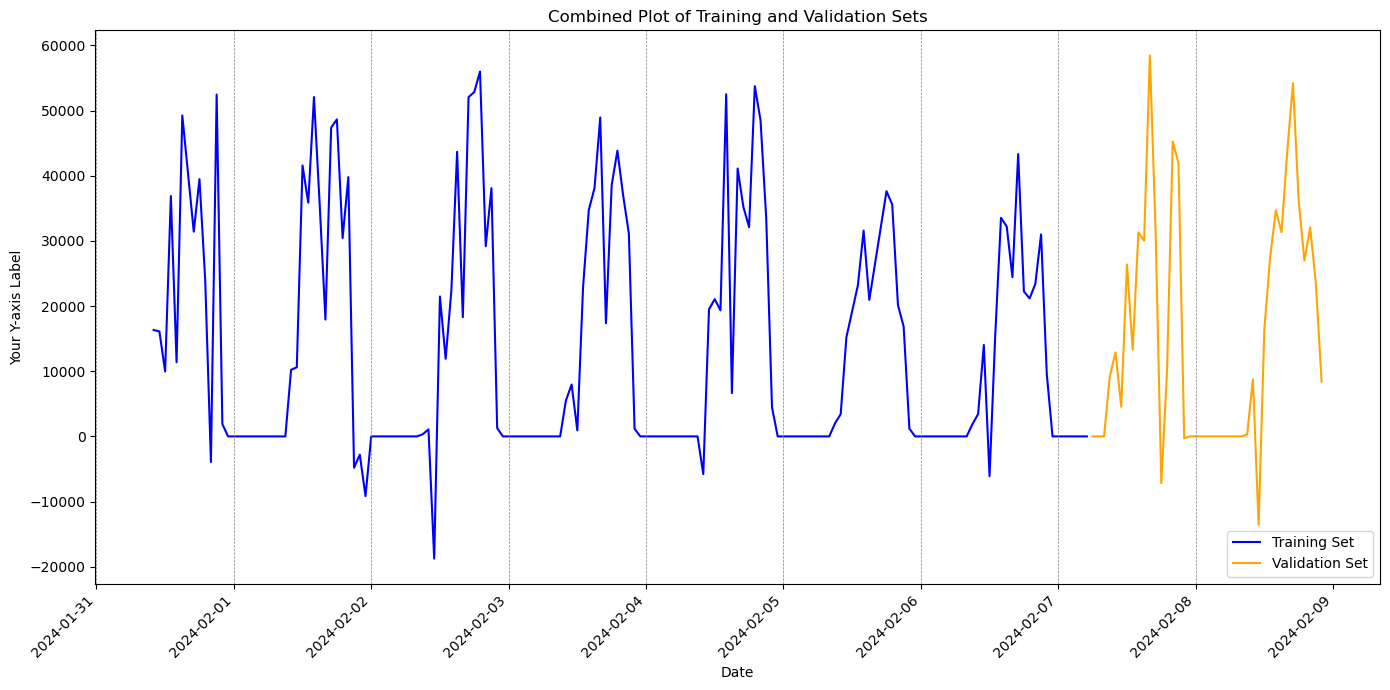

In [18]:
plt.figure(figsize=(14, 7))

plt.plot(train_df.index, train_df[f'{desired_column}'], label='Training Set', color='blue')
plt.plot(valid_df.index, valid_df[f'{desired_column}'], label='Validation Set', color='orange')

plt.xlabel('Date')
plt.ylabel('Your Y-axis Label')
plt.title('Combined Plot of Training and Validation Sets')

plt.gca().xaxis.set_major_locator(mdates.DayLocator()) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45, ha='right')

for date in np.unique(resampled_df.index.date):
    plt.axvline(x=date, color='gray', linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout() 
plt.show()

## Normalization

In [19]:
train_original = train_df.copy()
valid_original = valid_df.copy()
train_original_stats = train_original.describe().to_dict()

train_original.describe()

NetAmountWOVat  HourInterval   DayOfWeek  NetAmountWOVat Before 1
count      162.000000    162.000000  162.000000               162.000000
mean     13545.942778     11.567901    4.049383             13591.899198
std      17835.364789      7.031320    2.021015             17809.817537
min     -18747.920000      0.000000    1.000000            -18747.920000
25%          0.000000      5.000000    2.000000                 0.000000
50%       1226.130000     12.000000    4.000000              1561.635000
75%      28517.032500     18.000000    6.000000             28517.032500
max      55993.660000     23.000000    7.000000             55993.660000

In [20]:
for column in train_df:
    if column in ['HourInterval', 'DayOfWeek']:
        continue
        
    train_df[column] = (train_df[column] - train_original[f'{desired_column}'].mean()) / train_original[f'{desired_column}'].std()
    
for column in valid_df:
    if column in ['HourInterval', 'DayOfWeek']:
        continue

    valid_df[column] = (valid_df[column] - train_original[f'{desired_column}'].mean()) / train_original[f'{desired_column}'].std()

In [21]:
train_df.describe()

NetAmountWOVat  HourInterval   DayOfWeek  NetAmountWOVat Before 1
count    1.620000e+02    162.000000  162.000000               162.000000
mean    -2.741291e-17     11.567901    4.049383                 0.002577
std      1.000000e+00      7.031320    2.021015                 0.998568
min     -1.810665e+00      0.000000    1.000000                -1.810665
25%     -7.594991e-01      5.000000    2.000000                -0.759499
50%     -6.907519e-01     12.000000    4.000000                -0.671941
75%      8.394047e-01     18.000000    6.000000                 0.839405
max      2.379975e+00     23.000000    7.000000                 2.379975

In [22]:
valid_df.describe()

NetAmountWOVat  HourInterval  DayOfWeek  NetAmountWOVat Before 1
count       41.000000     41.000000  41.000000                41.000000
mean         0.112993     12.536585   3.560976                 0.101487
std          1.029418      6.364344   0.502433                 1.036621
min         -1.518725      0.000000   3.000000                -1.518725
25%         -0.759499      8.000000   3.000000                -0.759499
50%         -0.244404     13.000000   4.000000                -0.244404
75%          0.996013     18.000000   4.000000                 0.996013
max          2.518003     23.000000   4.000000                 2.518003

In [23]:
train_df.head(3)

NetAmountWOVat  HourInterval  DayOfWeek  \
TransactionDateTime                                            
2024-01-31 10:00:00        0.155641            10          3   
2024-01-31 11:00:00        0.143923            11          3   
2024-01-31 12:00:00       -0.201304            12          3   

                     NetAmountWOVat Before 1  
TransactionDateTime                           
2024-01-31 10:00:00                -0.342073  
2024-01-31 11:00:00                 0.155641  
2024-01-31 12:00:00                 0.143923

In [24]:
valid_df.head(4)

NetAmountWOVat  HourInterval  DayOfWeek  \
TransactionDateTime                                            
2024-02-07 06:00:00       -0.759499             6          3   
2024-02-07 07:00:00       -0.759499             7          3   
2024-02-07 08:00:00       -0.759499             8          3   
2024-02-07 09:00:00       -0.244404             9          3   

                     NetAmountWOVat Before 1  
TransactionDateTime                           
2024-02-07 06:00:00                -0.759499  
2024-02-07 07:00:00                -0.759499  
2024-02-07 08:00:00                -0.759499  
2024-02-07 09:00:00                -0.759499

## Datasets

In [25]:
X_train, y_train = train_df.drop(columns=[desired_column]), train_df[desired_column]
X_valid, y_valid = valid_df.drop(columns=[desired_column]), valid_df[desired_column]

In [26]:
X_train

HourInterval  DayOfWeek  NetAmountWOVat Before 1
TransactionDateTime                                                  
2024-01-31 10:00:00            10          3                -0.342073
2024-01-31 11:00:00            11          3                 0.155641
2024-01-31 12:00:00            12          3                 0.143923
2024-01-31 13:00:00            13          3                -0.201304
2024-01-31 14:00:00            14          3                 1.308498
2024-01-31 15:00:00            15          3                -0.121729
2024-01-31 17:00:00            17          3                 2.002030
2024-01-31 18:00:00            18          3                 1.002487
2024-01-31 19:00:00            19          3                 1.454462
2024-01-31 20:00:00            20          3                 0.586378
2024-01-31 21:00:00            21          3                -0.979875
2024-01-31 22:00:00            22          3                 2.181818
2024-01-31 23:00:00            23          3                -0.654137
2024-02-01 00:00:00             0          4                -0.759499
2024-02-01 01:00:00             1          4                -0.759499
2024-02-01 02:00:00             2          4                -0.759499
2024-02-01 03:00:00             3          4                -0.759499
2024-02-01 04:00:00             4          4                -0.759499
2024-02-01 05:00:00             5          4                -0.759499
2024-02-01 06:00:00             6          4                -0.759499
2024-02-01 07:00:00             7          4                -0.759499
2024-02-01 08:00:00             8          4                -0.759499
2024-02-01 09:00:00             9          4                -0.759499
2024-02-01 10:00:00            10          4                -0.759499
2024-02-01 11:00:00            11          4                -0.186828
2024-02-01 12:00:00            12          4                -0.164682
2024-02-01 13:00:00            13          4                 1.571691
2024-02-01 14:00:00            14          4                 1.251139
2024-02-01 15:00:00            15          4                 2.160352
2024-02-01 16:00:00            16          4                 1.233339
2024-02-01 17:00:00            17          4                 0.245823
2024-02-01 18:00:00            18          4                 1.897149
2024-02-01 19:00:00            19          4                 1.968363
2024-02-01 20:00:00            20          4                 0.947059
2024-02-01 21:00:00            21          4                 1.470562
2024-02-01 22:00:00            22          4                -1.029060
2024-02-01 23:00:00            23          4                -0.916363
2024-02-02 00:00:00             0          5                -1.273412
2024-02-02 01:00:00             1          5                -0.759499
2024-02-02 02:00:00             2          5                -0.759499
2024-02-02 03:00:00             3          5                -0.759499
2024-02-02 04:00:00             4          5                -0.759499
2024-02-02 05:00:00             5          5                -0.759499
2024-02-02 06:00:00             6          5                -0.759499
2024-02-02 07:00:00             7          5                -0.759499
2024-02-02 08:00:00             8          5                -0.759499
2024-02-02 09:00:00             9          5                -0.759499
2024-02-02 10:00:00            10          5                -0.740810
2024-02-02 11:00:00            11          5                -0.699056
2024-02-02 12:00:00            12          5                -1.810665
2024-02-02 13:00:00            13          5                 0.444084
2024-02-02 14:00:00            14          5                -0.091863
2024-02-02 15:00:00            15          5                 0.497607
2024-02-02 16:00:00            16          5                 1.689634
2024-02-02 17:00:00            17          5                 0.266659
2024-02-02 18:00:00            

In [27]:
y_train

TransactionDateTime
2024-01-31 10:00:00    0.155641
2024-01-31 11:00:00    0.143923
2024-01-31 12:00:00   -0.201304
2024-01-31 13:00:00    1.308498
2024-01-31 14:00:00   -0.121729
2024-01-31 15:00:00    2.002030
2024-01-31 17:00:00    1.002487
2024-01-31 18:00:00    1.454462
2024-01-31 19:00:00    0.586378
2024-01-31 20:00:00   -0.979875
2024-01-31 21:00:00    2.181818
2024-01-31 22:00:00   -0.654137
2024-01-31 23:00:00   -0.759499
2024-02-01 00:00:00   -0.759499
2024-02-01 01:00:00   -0.759499
2024-02-01 02:00:00   -0.759499
2024-02-01 03:00:00   -0.759499
2024-02-01 04:00:00   -0.759499
2024-02-01 05:00:00   -0.759499
2024-02-01 06:00:00   -0.759499
2024-02-01 07:00:00   -0.759499
2024-02-01 08:00:00   -0.759499
2024-02-01 09:00:00   -0.759499
2024-02-01 10:00:00   -0.186828
2024-02-01 11:00:00   -0.164682
2024-02-01 12:00:00    1.571691
2024-02-01 13:00:00    1.251139
2024-02-01 14:00:00    2.160352
2024-02-01 15:00:00    1.233339
2024-02-01 16:00:00    0.245823
2024-02-01 17:00:00 

# PHASE 3: Training

Bu modellerin hepsi Scikit-learn kütüphanesinden ya da onun üzerine inşa edilmiş kütüphanelerden oluştukları için bu modelleri optimize etmek için GridSearchCV kullandım. Veri setinin büyüklüğüne göre eğitim aşaması oldukça yavaşlayabilir.

## Main training phase

### Lasso

In [28]:
lasso_param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}

lasso_model = Lasso()

lasso_grid_search = GridSearchCV(lasso_model, lasso_param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid_search.fit(X_train, y_train)

best_lasso_params = lasso_grid_search.best_params_

print(f'Best Lasso Parameters: {best_lasso_params}')

lasso_model = Lasso(**best_lasso_params)  
lasso_model.fit(X_train, y_train)

lasso_pred = lasso_model.predict(X_valid)

mse = mean_squared_error(y_valid, lasso_pred)
print(f'Mean Squared Error: {mse}')

Best Lasso Parameters: {'alpha': 0.01}
Mean Squared Error: 0.6007757693038304


### Ridge

In [29]:
ridge_param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}

ridge_model = Ridge()

ridge_grid_search = GridSearchCV(ridge_model, ridge_param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X_train, y_train)

best_ridge_params = ridge_grid_search.best_params_

print(f'Best Ridge Parameters: {best_ridge_params}')

ridge_model = Ridge(**best_ridge_params)  
ridge_model.fit(X_train, y_train)

ridge_pred = ridge_model.predict(X_valid)

mse = mean_squared_error(y_valid, ridge_pred)
print(f'Mean Squared Error: {mse}')

Best Ridge Parameters: {'alpha': 0.1}
Mean Squared Error: 0.6012525436780449


### Elastic Net

In [30]:
elasticnet_param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9]}

elasticnet_model = ElasticNet()

elasticnet_grid_search = GridSearchCV(elasticnet_model, elasticnet_param_grid, cv=5, scoring='neg_mean_squared_error')
elasticnet_grid_search.fit(X_train, y_train)

best_elasticnet_params = elasticnet_grid_search.best_params_

print(f'Best Elastic Net Parameters: {best_elasticnet_params}')

elastic_model = ElasticNet(**best_elasticnet_params)  
elastic_model.fit(X_train, y_train)

elastic_pred = elastic_model.predict(X_valid)

mse = mean_squared_error(y_valid, elastic_pred)
print(f'Mean Squared Error: {mse}')

Best Elastic Net Parameters: {'alpha': 0.01, 'l1_ratio': 0.7}
Mean Squared Error: 0.6008192968077803


## Huber Regression

In [31]:
huber_param_grid = {'epsilon': [1.35, 1.5, 1.75]}
huber_grid_search = GridSearchCV(HuberRegressor(), huber_param_grid, cv=5, scoring='neg_mean_squared_error')
huber_grid_search.fit(X_train, y_train)
huber_model = huber_grid_search.best_estimator_

huber_best_predictions = huber_model.predict(X_valid)
mse = mean_squared_error(y_valid, huber_best_predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.6170592653397688


## Quantile Regression

In [32]:
quantile_param_grid = {'alpha': [0.1, 0.5, 0.9]}
quantile_grid_search = GridSearchCV(QuantileRegressor(), quantile_param_grid, cv=5, scoring='neg_mean_squared_error')
quantile_grid_search.fit(X_train, y_train)
quantile_model = quantile_grid_search.best_estimator_

quantile_best_predictions = quantile_model.predict(X_valid)
mse = mean_squared_error(y_valid, quantile_best_predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.6267560760973035


## Bayesian Ridge

In [33]:
bayesian_model = BayesianRidge()
bayesian_model.fit(X_train, y_train)

bayesian_predictions = bayesian_model.predict(X_valid)
mse = mean_squared_error(y_valid, bayesian_predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.6005770400676775


## SVR

In [34]:
svr_param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.5, 1.0],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']  # Add other kernels you want to explore
}

svr_grid_search = GridSearchCV(SVR(), svr_param_grid, cv=5, scoring='neg_mean_squared_error')
svr_grid_search.fit(X_train, y_train)
svr_model = svr_grid_search.best_estimator_

svr_best_predictions = svr_model.predict(X_valid)
mse = mean_squared_error(y_valid, svr_best_predictions)
print(f'Mean Squared Error: {mse}')
print(f'Best SVR Parameters: {svr_grid_search.best_params_}')

Mean Squared Error: 0.41237588693667576
Best SVR Parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}


## Poly Regression

In [35]:
polyreg = make_pipeline(PolynomialFeatures(), LinearRegression())

param_grid = {'polynomialfeatures__degree': [2, 3, 4]}  # You can extend the list as needed

grid_search = GridSearchCV(polyreg, param_grid, scoring='neg_mean_squared_error', cv=5)

grid_search.fit(X_train, y_train)

poly_model = grid_search.best_estimator_

polyreg_predictions = poly_model.predict(X_valid)

polyreg_mse = mean_squared_error(y_valid, polyreg_predictions)

print(f"Best Polynomial Degree: {grid_search.best_params_['polynomialfeatures__degree']}")
print(f"Best Polynomial Regression MSE: {polyreg_mse}")

Best Polynomial Degree: 3
Best Polynomial Regression MSE: 0.4407677585667949


In [ ]:
import pickle

# Uygulama için kullanmak adına modeli kaydetme kısmı
with open(r'MODELS\polyreg_model.pkl', 'wb') as f:
    pickle.dump(polyreg_model, f)

# PHASE 4: Testing

## Plot inference

In [36]:
desired_column = "NetAmountWOVat"

In [37]:
mean = train_original_stats[desired_column]["mean"]
std = train_original_stats[desired_column]["std"]

# Asıl
actual_train_values = train_df[desired_column]
actual_valid_values = valid_df[desired_column]

actual_train_values_denorm = train_df[desired_column] * std + mean
actual_valid_values_denorm = valid_df[desired_column] * std + mean

# Lasso
predicted_train_values_lasso = lasso_model.predict(X_train)
predicted_valid_values_lasso = lasso_model.predict(X_valid)

predicted_train_values_lasso_denorm = predicted_train_values_lasso * std + mean
predicted_valid_values_lasso_denorm = predicted_valid_values_lasso * std + mean

# Ridge
predicted_train_values_ridge = ridge_model.predict(X_train)
predicted_valid_values_ridge = ridge_model.predict(X_valid)

predicted_train_values_ridge_denorm = predicted_train_values_ridge * std + mean
predicted_valid_values_ridge_denorm = predicted_valid_values_ridge * std + mean

# Elastic Net
predicted_train_values_elastic = elastic_model.predict(X_train)
predicted_valid_values_elastic = elastic_model.predict(X_valid)

predicted_train_values_elastic_denorm = predicted_train_values_elastic * std + mean
predicted_valid_values_elastic_denorm = predicted_valid_values_elastic * std + mean

# Huber
predicted_train_values_huber = huber_model.predict(X_train)
predicted_valid_values_huber = huber_model.predict(X_valid)

predicted_train_values_huber_denorm = predicted_train_values_huber * std + mean
predicted_valid_values_huber_denorm = predicted_valid_values_huber * std + mean

# Quantile
predicted_train_values_quantile = quantile_model.predict(X_train)
predicted_valid_values_quantile = quantile_model.predict(X_valid)

predicted_train_values_quantile_denorm = predicted_train_values_quantile * std + mean
predicted_valid_values_quantile_denorm = predicted_valid_values_quantile * std + mean

# Bayesian
predicted_train_values_bayesian = bayesian_model.predict(X_train)
predicted_valid_values_bayesian = bayesian_model.predict(X_valid)

predicted_train_values_bayesian_denorm = predicted_train_values_bayesian * std + mean
predicted_valid_values_bayesian_denorm = predicted_valid_values_bayesian * std + mean

# SVR
predicted_train_values_svr = svr_model.predict(X_train)
predicted_valid_values_svr = svr_model.predict(X_valid)

predicted_train_values_svr_denorm = predicted_train_values_svr * std + mean
predicted_valid_values_svr_denorm = predicted_valid_values_svr * std + mean

# Poly
predicted_train_values_poly = poly_model.predict(X_train)
predicted_valid_values_poly = poly_model.predict(X_valid)

predicted_train_values_poly_denorm = predicted_train_values_poly * std + mean
predicted_valid_values_poly_denorm = predicted_valid_values_poly * std + mean

# Ensemble 
ensemble_train_predictions = (predicted_train_values_lasso + predicted_train_values_ridge + predicted_train_values_elastic +
                              predicted_train_values_huber + predicted_train_values_quantile + predicted_train_values_bayesian +
                              predicted_train_values_svr + predicted_train_values_poly) / 8
ensemble_valid_predictions = (predicted_valid_values_lasso + predicted_valid_values_ridge + predicted_valid_values_elastic +
                              predicted_valid_values_huber + predicted_valid_values_quantile + predicted_valid_values_bayesian +
                              predicted_valid_values_svr + predicted_valid_values_poly) / 8

ensemble_train_predictions_denorm = (predicted_train_values_lasso_denorm + predicted_train_values_ridge_denorm + predicted_train_values_elastic_denorm) / 3
ensemble_valid_predictions_denorm = (predicted_valid_values_lasso_denorm + predicted_valid_values_ridge_denorm + predicted_valid_values_elastic_denorm) / 3

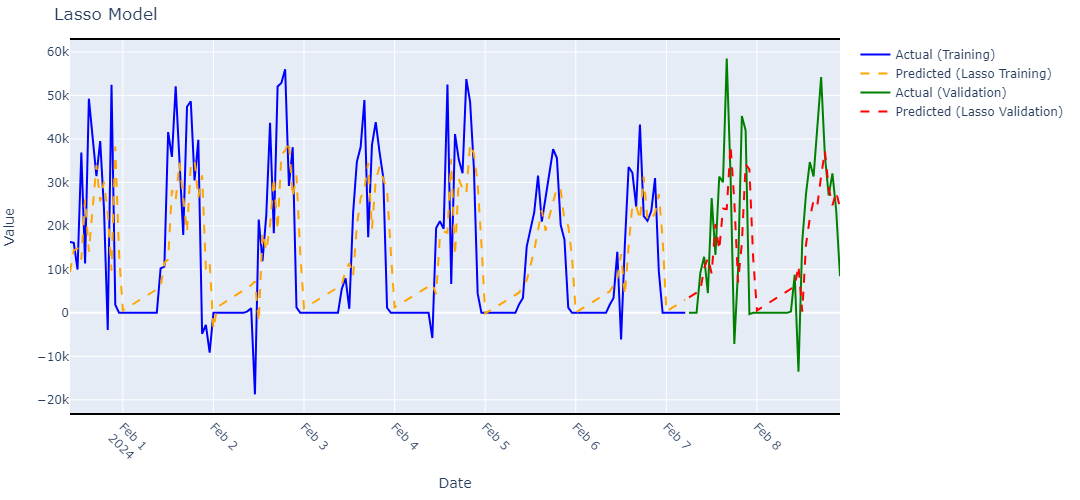

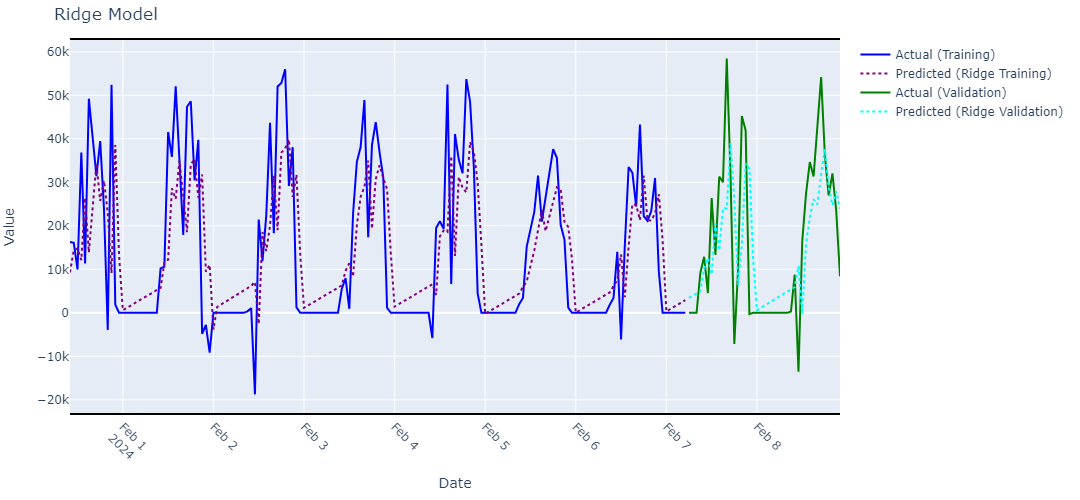

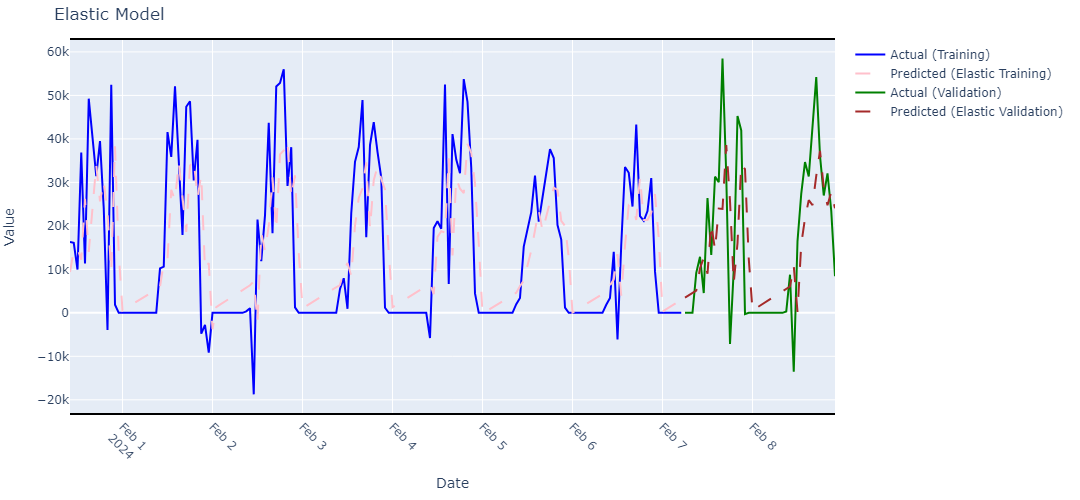

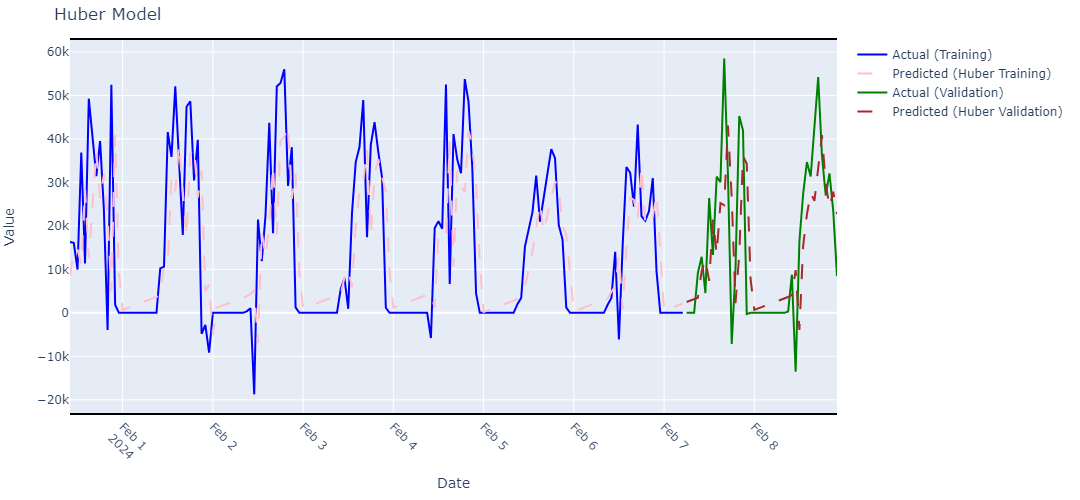

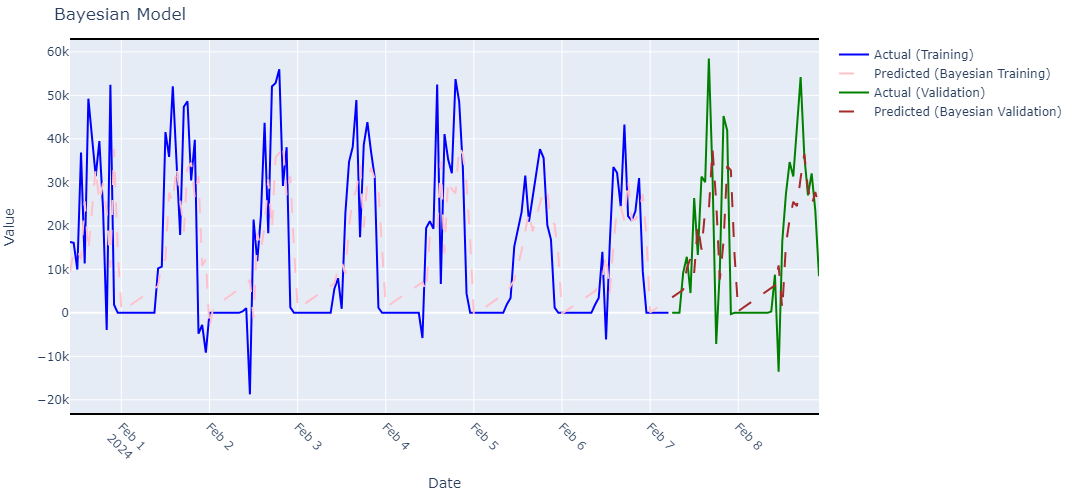

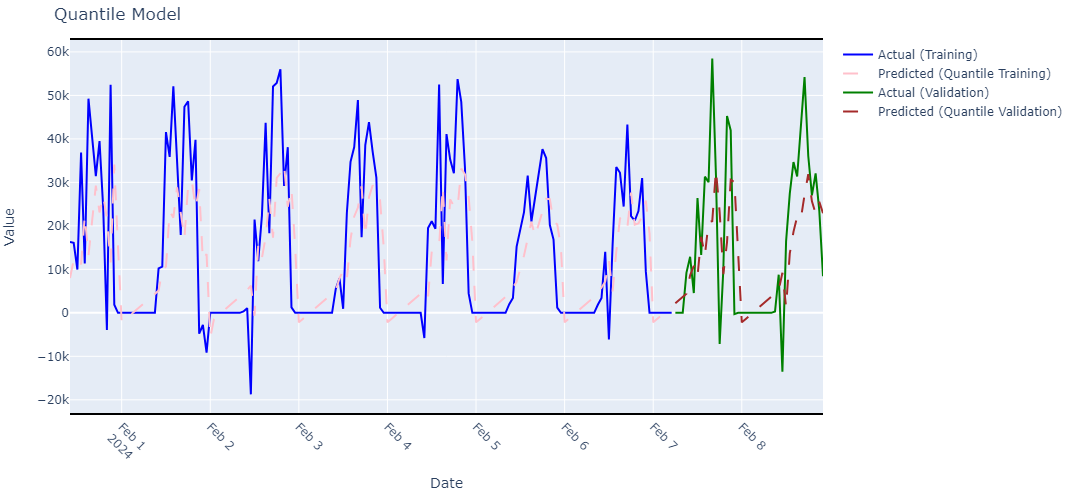

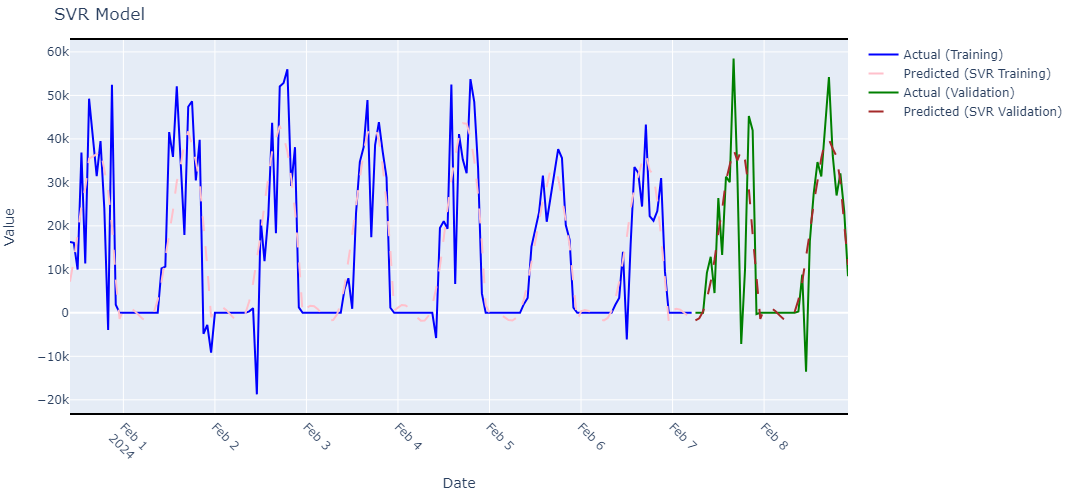

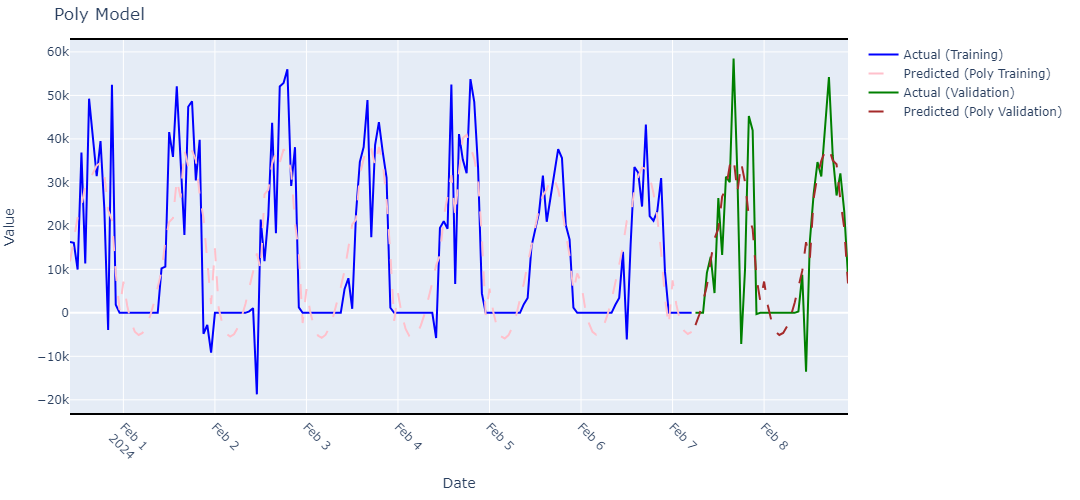

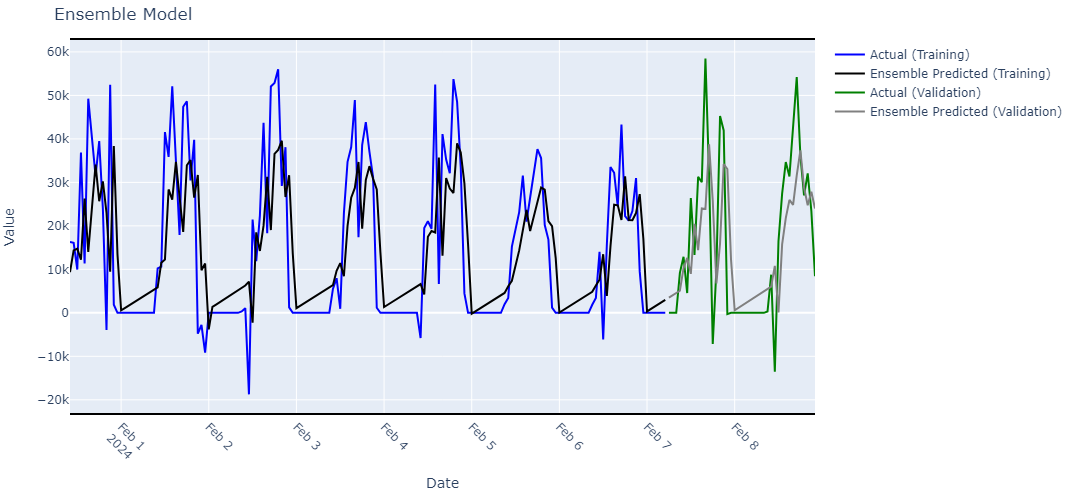

In [38]:
dates = resampled_df.index

trace_actual_train = go.Scatter(x=dates[:len(actual_train_values_denorm)], y=actual_train_values_denorm, mode='lines', name='Actual (Training)', line=dict(color='blue'))
trace_actual_valid = go.Scatter(x=dates[-len(actual_valid_values_denorm):], y=actual_valid_values_denorm, mode='lines', name='Actual (Validation)', line=dict(color='green'))

# Lasso
trace_predicted_train_lasso = go.Scatter(x=dates[:len(predicted_train_values_lasso_denorm)], y=predicted_train_values_lasso_denorm, mode='lines', name='Predicted (Lasso Training)', line=dict(color='orange', dash='dash'))
trace_predicted_valid_lasso = go.Scatter(x=dates[-len(predicted_valid_values_lasso_denorm):], y=predicted_valid_values_lasso_denorm, mode='lines', name='Predicted (Lasso Validation)', line=dict(color='red', dash='dash'))

# Ridge
trace_predicted_train_ridge = go.Scatter(x=dates[:len(predicted_train_values_ridge_denorm)], y=predicted_train_values_ridge_denorm, mode='lines', name='Predicted (Ridge Training)', line=dict(color='purple', dash='dot'))
trace_predicted_valid_ridge = go.Scatter(x=dates[-len(predicted_valid_values_ridge_denorm):], y=predicted_valid_values_ridge_denorm, mode='lines', name='Predicted (Ridge Validation)', line=dict(color='cyan', dash='dot'))

# Elastic Net
trace_predicted_train_elastic = go.Scatter(x=dates[:len(predicted_train_values_elastic_denorm)], y=predicted_train_values_elastic_denorm, mode='lines', name='Predicted (Elastic Training)', line=dict(color='pink', dash='longdash'))
trace_predicted_valid_elastic = go.Scatter(x=dates[-len(predicted_valid_values_elastic_denorm):], y=predicted_valid_values_elastic_denorm, mode='lines', name='Predicted (Elastic Validation)', line=dict(color='brown', dash='longdash'))

# Huber
trace_predicted_train_huber = go.Scatter(x=dates[:len(predicted_train_values_huber_denorm)], y=predicted_train_values_huber_denorm, mode='lines', name='Predicted (Huber Training)', line=dict(color='pink', dash='longdash'))
trace_predicted_valid_huber = go.Scatter(x=dates[-len(predicted_valid_values_huber_denorm):], y=predicted_valid_values_huber_denorm, mode='lines', name='Predicted (Huber Validation)', line=dict(color='brown', dash='longdash'))

# Quantile
trace_predicted_train_quantile = go.Scatter(x=dates[:len(predicted_train_values_quantile_denorm)], y=predicted_train_values_quantile_denorm, mode='lines', name='Predicted (Quantile Training)', line=dict(color='pink', dash='longdash'))
trace_predicted_valid_quantile = go.Scatter(x=dates[-len(predicted_valid_values_quantile_denorm):], y=predicted_valid_values_quantile_denorm, mode='lines', name='Predicted (Quantile Validation)', line=dict(color='brown', dash='longdash'))

# Bayesian
trace_predicted_train_bayesian = go.Scatter(x=dates[:len(predicted_train_values_bayesian_denorm)], y=predicted_train_values_bayesian_denorm, mode='lines', name='Predicted (Bayesian Training)', line=dict(color='pink', dash='longdash'))
trace_predicted_valid_bayesian = go.Scatter(x=dates[-len(predicted_valid_values_bayesian_denorm):], y=predicted_valid_values_bayesian_denorm, mode='lines', name='Predicted (Bayesian Validation)', line=dict(color='brown', dash='longdash'))

# SVR
trace_predicted_train_svr = go.Scatter(x=dates[:len(predicted_train_values_svr_denorm)], y=predicted_train_values_svr_denorm, mode='lines', name='Predicted (SVR Training)', line=dict(color='pink', dash='longdash'))
trace_predicted_valid_svr = go.Scatter(x=dates[-len(predicted_valid_values_svr_denorm):], y=predicted_valid_values_svr_denorm, mode='lines', name='Predicted (SVR Validation)', line=dict(color='brown', dash='longdash'))

# Poly
trace_predicted_train_poly = go.Scatter(x=dates[:len(predicted_train_values_poly_denorm)], y=predicted_train_values_poly_denorm, mode='lines', name='Predicted (Poly Training)', line=dict(color='pink', dash='longdash'))
trace_predicted_valid_poly = go.Scatter(x=dates[-len(predicted_valid_values_poly_denorm):], y=predicted_valid_values_poly_denorm, mode='lines', name='Predicted (Poly Validation)', line=dict(color='brown', dash='longdash'))

# Ensemble
trace_train_ensemble = go.Scatter(x=dates[:len(ensemble_train_predictions_denorm)], y=ensemble_train_predictions_denorm, mode='lines', name='Ensemble Predicted (Training)', line=dict(color='black', dash='solid'))
trace_valid_ensemble = go.Scatter(x=dates[-len(ensemble_valid_predictions_denorm):], y=ensemble_valid_predictions_denorm, mode='lines', name='Ensemble Predicted (Validation)', line=dict(color='gray', dash='solid'))

layout_lasso = go.Layout(
    title='Lasso Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_ridge = go.Layout(
    title='Ridge Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_elastic = go.Layout(
    title='Elastic Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_huber = go.Layout(
    title='Huber Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_quantile = go.Layout(
    title='Quantile Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_bayesian = go.Layout(
    title='Bayesian Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_svr = go.Layout(
    title='SVR Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_poly = go.Layout(
    title='Poly Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_ensemble = go.Layout(
    title='Ensemble Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

fig_lasso = go.Figure(data=[trace_actual_train, trace_predicted_train_lasso, trace_actual_valid, trace_predicted_valid_lasso], layout=layout_lasso)
fig_ridge = go.Figure(data=[trace_actual_train, trace_predicted_train_ridge, trace_actual_valid, trace_predicted_valid_ridge], layout=layout_ridge)
fig_elastic = go.Figure(data=[trace_actual_train, trace_predicted_train_elastic, trace_actual_valid, trace_predicted_valid_elastic], layout=layout_elastic)
fig_huber = go.Figure(data=[trace_actual_train, trace_predicted_train_huber, trace_actual_valid, trace_predicted_valid_huber], layout=layout_huber)
fig_bayesian = go.Figure(data=[trace_actual_train, trace_predicted_train_bayesian, trace_actual_valid, trace_predicted_valid_bayesian], layout=layout_bayesian)
fig_quantile = go.Figure(data=[trace_actual_train, trace_predicted_train_quantile, trace_actual_valid, trace_predicted_valid_quantile], layout=layout_quantile)
fig_svr = go.Figure(data=[trace_actual_train, trace_predicted_train_svr, trace_actual_valid, trace_predicted_valid_svr], layout=layout_svr)
fig_poly = go.Figure(data=[trace_actual_train, trace_predicted_train_poly, trace_actual_valid, trace_predicted_valid_poly], layout=layout_poly)
fig_ensemble = go.Figure(data=[trace_actual_train, trace_train_ensemble, trace_actual_valid, trace_valid_ensemble], layout=layout_ensemble)

fig_lasso.show()
fig_ridge.show()
fig_elastic.show()
fig_huber.show()
fig_bayesian.show()
fig_quantile.show()
fig_svr.show()
fig_poly.show()
fig_ensemble.show()

In [39]:
predictions_train_df = pd.DataFrame({
    'Date': train_df.index,
    f'Actual {desired_column}': actual_train_values_denorm,
    f'Lasso Predicted {desired_column}': predicted_train_values_lasso_denorm,
    f'Ridge Predicted {desired_column}': predicted_train_values_ridge_denorm,
    f'Elastic Predicted {desired_column}': predicted_train_values_elastic_denorm,
    f'Huber Predicted {desired_column}': predicted_train_values_huber_denorm,
    f'Quantile Predicted {desired_column}': predicted_train_values_quantile_denorm,
    f'Bayesian Predicted {desired_column}': predicted_train_values_bayesian_denorm,
    f'SVR Predicted {desired_column}': predicted_train_values_svr_denorm,
    f'Poly Predicted {desired_column}': predicted_train_values_poly_denorm,
    f'Ensemble Predicted {desired_column}': ensemble_train_predictions_denorm
})

predictions_valid_df = pd.DataFrame({
    'Date': valid_df.index,
    f'Actual {desired_column}': actual_valid_values_denorm,
    f'Lasso Predicted {desired_column}': predicted_valid_values_lasso_denorm,
    f'Ridge Predicted {desired_column}': predicted_valid_values_ridge_denorm,
    f'Elastic Predicted {desired_column}': predicted_valid_values_elastic_denorm,
    f'Huber Predicted {desired_column}': predicted_valid_values_huber_denorm,
    f'Quantile Predicted {desired_column}': predicted_valid_values_quantile_denorm,
    f'Bayesian Predicted {desired_column}': predicted_valid_values_bayesian_denorm,
    f'SVR Predicted {desired_column}': predicted_valid_values_svr_denorm,
    f'Poly Predicted {desired_column}': predicted_valid_values_poly_denorm,
    f'Ensemble Predicted {desired_column}': ensemble_valid_predictions_denorm
})


predictions_all_df = pd.concat([predictions_train_df, predictions_valid_df], ignore_index=True)
predictions_all_df.set_index('Date', inplace=True)

result_df = predictions_all_df.copy()
result_df.tail(10)

Actual NetAmountWOVat  Lasso Predicted NetAmountWOVat  \
Date                                                                         
2024-02-08 13:00:00               27416.69                    15740.116052   
2024-02-08 14:00:00               34684.19                    21717.742879   
2024-02-08 15:00:00               31353.18                    25869.817748   
2024-02-08 16:00:00               43761.77                    24751.516444   
2024-02-08 17:00:00               54206.70                    31460.127868   
2024-02-08 18:00:00               36130.63                    37192.259874   
2024-02-08 19:00:00               26992.63                    28741.605918   
2024-02-08 20:00:00               32083.99                    24735.632503   
2024-02-08 21:00:00               23429.17                    27805.566919   
2024-02-08 22:00:00                8413.79                    24039.866935   

                     Ridge Predicted NetAmountWOVat  \
Date                                                  
2024-02-08 13:00:00                    15750.662802   
2024-02-08 14:00:00                    21875.578458   
2024-02-08 15:00:00                    26117.885193   
2024-02-08 16:00:00                    24925.092058   
2024-02-08 17:00:00                    31803.838971   
2024-02-08 18:00:00                    37675.586955   
2024-02-08 19:00:00                    28921.271146   
2024-02-08 20:00:00                    24750.552756   
2024-02-08 21:00:00                    27876.897131   
2024-02-08 22:00:00                    23953.961831   

                     Elastic Predicted NetAmountWOVat  \
Date                                                    
2024-02-08 13:00:00                      15742.024586   
2024-02-08 14:00:00                      21740.076966   
2024-02-08 15:00:00                      25904.891660   
2024-02-08 16:00:00                      24777.141449   
2024-02-08 17:00:00                      31509.255935   
2024-02-08 18:00:00                      37260.779941   
2024-02-08 19:00:00                      28769.807250   
2024-02-08 20:00:00                      24742.227584   
2024-02-08 21:00:00                      27820.345922   
2024-02-08 22:00:00                      24034.051258   

                     Huber Predicted NetAmountWOVat  \
Date                                                  
2024-02-08 13:00:00                    15370.272393   
2024-02-08 14:00:00                    22611.282241   
2024-02-08 15:00:00                    27532.846434   
2024-02-08 16:00:00                    25758.161271   
2024-02-08 17:00:00                    33927.919842   
2024-02-08 18:00:00                    40857.017508   
2024-02-08 19:00:00                    29766.249375   
2024-02-08 20:00:00                    24322.647257   
2024-02-08 21:00:00                    27869.303461   
2024-02-08 22:00:00                    22730.979515   

                     Quantile Predicted NetAmountWOVat  \
Date                                                     
2024-02-08 13:00:00                       13658.758792   
2024-02-08 14:00:00                       18613.227302   
2024-02-08 15:00:00                       22149.721531   
2024-02-08 16:00:00                       21592.518047   
2024-02-08 17:00:00                       27114.769554   
2024-02-08 18:00:00                       31878.553083   
2024-02-08 19:00:00                       25626.037863   
2024-02-08 20:00:00                       22825.871768   
2024-02-08 21:00:00                       25521.827153   
2024-02-08 22:00:00                       22908.290391   

                     Bayesian Predicted NetAmountWOVat  \
Date                                                     
2024-02-08 13:00:00                       15731.642088   
2024-02-08 14:00:00                       21505.208173   
2024-02-08 15:00:00                       25535.483554   
2024-02-08 16:00:00                       24532.871351   
2024-02-08 17:00:00             

## Table Inference

In [40]:
result_df["Original_Status"] = np.where(result_df[f"Actual {desired_column}"].shift(-1) > result_df[f"Actual {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_Lasso"] = np.where(result_df[f"Lasso Predicted {desired_column}"].shift(-1) > result_df[f"Lasso Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_Ridge"] = np.where(result_df[f"Ridge Predicted {desired_column}"].shift(-1) > result_df[f"Ridge Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_Elastic"] = np.where(result_df[f"Elastic Predicted {desired_column}"].shift(-1) > result_df[f"Elastic Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_Huber"] = np.where(result_df[f"Huber Predicted {desired_column}"].shift(-1) > result_df[f"Huber Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_Quantile"] = np.where(result_df[f"Quantile Predicted {desired_column}"].shift(-1) > result_df[f"Quantile Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_Bayesian"] = np.where(result_df[f"Bayesian Predicted {desired_column}"].shift(-1) > result_df[f"Bayesian Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_SVR"] = np.where(result_df[f"SVR Predicted {desired_column}"].shift(-1) > result_df[f"SVR Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_Poly"] = np.where(result_df[f"Poly Predicted {desired_column}"].shift(-1) > result_df[f"Poly Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Ensemble_Status"] = np.where(result_df[f"Ensemble Predicted {desired_column}"].shift(-1) > result_df[f"Ensemble Predicted {desired_column}"], "Will Rise", "Will Fall")

result_df.tail(10)

Actual NetAmountWOVat  Lasso Predicted NetAmountWOVat  \
Date                                                                         
2024-02-08 13:00:00               27416.69                    15740.116052   
2024-02-08 14:00:00               34684.19                    21717.742879   
2024-02-08 15:00:00               31353.18                    25869.817748   
2024-02-08 16:00:00               43761.77                    24751.516444   
2024-02-08 17:00:00               54206.70                    31460.127868   
2024-02-08 18:00:00               36130.63                    37192.259874   
2024-02-08 19:00:00               26992.63                    28741.605918   
2024-02-08 20:00:00               32083.99                    24735.632503   
2024-02-08 21:00:00               23429.17                    27805.566919   
2024-02-08 22:00:00                8413.79                    24039.866935   

                     Ridge Predicted NetAmountWOVat  \
Date                                                  
2024-02-08 13:00:00                    15750.662802   
2024-02-08 14:00:00                    21875.578458   
2024-02-08 15:00:00                    26117.885193   
2024-02-08 16:00:00                    24925.092058   
2024-02-08 17:00:00                    31803.838971   
2024-02-08 18:00:00                    37675.586955   
2024-02-08 19:00:00                    28921.271146   
2024-02-08 20:00:00                    24750.552756   
2024-02-08 21:00:00                    27876.897131   
2024-02-08 22:00:00                    23953.961831   

                     Elastic Predicted NetAmountWOVat  \
Date                                                    
2024-02-08 13:00:00                      15742.024586   
2024-02-08 14:00:00                      21740.076966   
2024-02-08 15:00:00                      25904.891660   
2024-02-08 16:00:00                      24777.141449   
2024-02-08 17:00:00                      31509.255935   
2024-02-08 18:00:00                      37260.779941   
2024-02-08 19:00:00                      28769.807250   
2024-02-08 20:00:00                      24742.227584   
2024-02-08 21:00:00                      27820.345922   
2024-02-08 22:00:00                      24034.051258   

                     Huber Predicted NetAmountWOVat  \
Date                                                  
2024-02-08 13:00:00                    15370.272393   
2024-02-08 14:00:00                    22611.282241   
2024-02-08 15:00:00                    27532.846434   
2024-02-08 16:00:00                    25758.161271   
2024-02-08 17:00:00                    33927.919842   
2024-02-08 18:00:00                    40857.017508   
2024-02-08 19:00:00                    29766.249375   
2024-02-08 20:00:00                    24322.647257   
2024-02-08 21:00:00                    27869.303461   
2024-02-08 22:00:00                    22730.979515   

                     Quantile Predicted NetAmountWOVat  \
Date                                                     
2024-02-08 13:00:00                       13658.758792   
2024-02-08 14:00:00                       18613.227302   
2024-02-08 15:00:00                       22149.721531   
2024-02-08 16:00:00                       21592.518047   
2024-02-08 17:00:00                       27114.769554   
2024-02-08 18:00:00                       31878.553083   
2024-02-08 19:00:00                       25626.037863   
2024-02-08 20:00:00                       22825.871768   
2024-02-08 21:00:00                       25521.827153   
2024-02-08 22:00:00                       22908.290391   

                     Bayesian Predicted NetAmountWOVat  \
Date                                                     
2024-02-08 13:00:00                       15731.642088   
2024-02-08 14:00:00                       21505.208173   
2024-02-08 15:00:00                       25535.483554   
2024-02-08 16:00:00                       24532.871351   
2024-02-08 17:00:00             

In [41]:
real_values = result_df[f'Actual {desired_column}'].sum()
lasso_values = result_df[f'Lasso Predicted {desired_column}'].sum()
ridge_values = result_df[f'Ridge Predicted {desired_column}'].sum()
elastic_values = result_df[f'Elastic Predicted {desired_column}'].sum()
huber_values = result_df[f'Huber Predicted {desired_column}'].sum()
quantile_values = result_df[f'Quantile Predicted {desired_column}'].sum()
bayesian_values = result_df[f'Bayesian Predicted {desired_column}'].sum()
svr_values = result_df[f'SVR Predicted {desired_column}'].sum()
poly_values = result_df[f'Poly Predicted {desired_column}'].sum()
ensemble_values = result_df[f'Ensemble Predicted {desired_column}'].sum()

print(f"Real {desired_column}:", real_values)
print(f"Lasso {desired_column}:", lasso_values)
print(f"Ridge {desired_column}:", ridge_values)
print(f"Elastic {desired_column}:", elastic_values)
print(f"Huber {desired_column}:", huber_values)
print(f"Quantile {desired_column}:", quantile_values)
print(f"Bayesian {desired_column}:", bayesian_values)
print(f"SVR {desired_column}:", svr_values)
print(f"Polyreg {desired_column}:", poly_values)
print(f"Ensemble {desired_column}:", ensemble_values)

print("-------------------------------------------")

print("The prediction offness:")
print("Lasso:", int(lasso_values - real_values))
print("Ridge:", int(ridge_values - real_values))
print("Elastic:", int(elastic_values - real_values))
print("Huber:", int(huber_values - real_values))
print("Quantile:", int(quantile_values - real_values))
print("Bayesian:", int(bayesian_values - real_values))
print("SVR:", int(svr_values - real_values))
print("Polyreg:", int(poly_values - real_values))

Real NetAmountWOVat: 2832452.57
Lasso NetAmountWOVat: 2802419.5604837453
Ridge NetAmountWOVat: 2801922.6257107994
Elastic NetAmountWOVat: 2802233.7758200625
Huber NetAmountWOVat: 2711203.79281474
Quantile NetAmountWOVat: 2391280.827518851
Bayesian NetAmountWOVat: 2801380.1103109457
SVR NetAmountWOVat: 2971720.2182200477
Polyreg NetAmountWOVat: 2842323.356415743
Ensemble NetAmountWOVat: 2802191.9873382025
-------------------------------------------
The prediction offness:
Lasso: -30033
Ridge: -30529
Elastic: -30218
Huber: -121248
Quantile: -441171
Bayesian: -31072
SVR: 139267
Polyreg: 9870


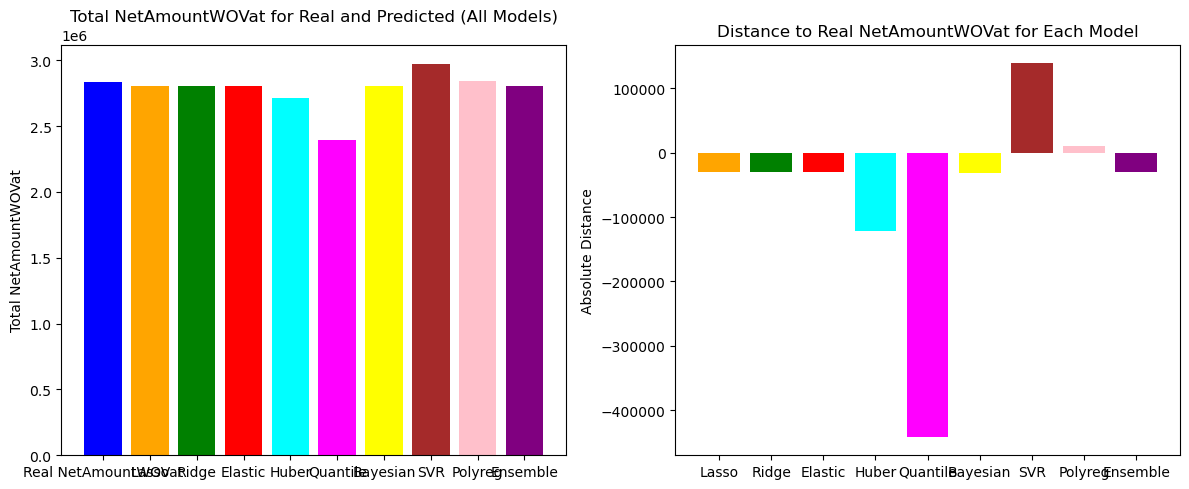

In [42]:
distance_lasso = lasso_values - real_values
distance_ridge = ridge_values - real_values
distance_elastic = elastic_values - real_values
distance_huber = huber_values - real_values
distance_quantile = quantile_values - real_values
distance_bayesian = bayesian_values - real_values
distance_svr = svr_values - real_values
distance_poly = poly_values - real_values
distance_ensemble = ensemble_values - real_values

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar([f'Real {desired_column}', 'Lasso', 'Ridge', 'Elastic', 'Huber', 'Quantile', 'Bayesian', 'SVR', 'Polyreg', 'Ensemble'],
            [real_values, lasso_values, ridge_values, elastic_values, huber_values, quantile_values, bayesian_values, svr_values, poly_values, ensemble_values],
            color=['blue', 'orange', 'green', 'red', 'cyan', 'magenta', 'yellow', 'brown', 'pink', 'purple'])
axes[0].set_title(f'Total {desired_column} for Real and Predicted (All Models)')
axes[0].set_ylabel(f'Total {desired_column}')

axes[1].bar(['Lasso', 'Ridge', 'Elastic', 'Huber', 'Quantile', 'Bayesian', 'SVR', 'Polyreg', 'Ensemble'],
            [distance_lasso, distance_ridge, distance_elastic, distance_huber, distance_quantile, distance_bayesian, distance_svr, distance_poly, distance_ensemble],
            color=['orange', 'green', 'red', 'cyan', 'magenta', 'yellow', 'brown', 'pink', 'purple'])
axes[1].set_title(f'Distance to Real {desired_column} for Each Model')
axes[1].set_ylabel('Absolute Distance')

plt.tight_layout()
plt.show()

# PHASE 5: Forecasting

## Prepare the emtpy set

In [43]:
start_timestamp = '2024-02-08 22:00:00'
end_timestamp = '2024-02-18 23:00:00'

forecast_timestamps = pd.date_range(start=start_timestamp, end=end_timestamp, freq='H')

forecast_df = pd.DataFrame(index=forecast_timestamps)

forecast_df[f'Forecasted {desired_column}'] = np.nan

forecast_df["HourInterval"] = forecast_df.index.hour
forecast_df['DayOfWeek'] = forecast_df.index.dayofweek + 1

for i in range(1, sequence_length+1):
    forecast_df[f'{desired_column} Before {i}'] = np.nan

forecast_df.head(4)

Forecasted NetAmountWOVat  HourInterval  DayOfWeek  \
2024-02-08 22:00:00                        NaN            22          4   
2024-02-08 23:00:00                        NaN            23          4   
2024-02-09 00:00:00                        NaN             0          5   
2024-02-09 01:00:00                        NaN             1          5   

                     NetAmountWOVat Before 1  
2024-02-08 22:00:00                      NaN  
2024-02-08 23:00:00                      NaN  
2024-02-09 00:00:00                      NaN  
2024-02-09 01:00:00                      NaN

In [44]:
forecast_df.iloc[:sequence_length] = valid_df.iloc[-sequence_length:]

for i in range(1, sequence_length+1):
    forecast_df.iloc[i, forecast_df.columns.get_loc(f'{desired_column} Before {i}')] = forecast_df.iloc[i-1][f'Forecasted {desired_column}']

In [45]:
print(forecast_df.shape)
forecast_df.head(6)

(242, 4)


Forecasted NetAmountWOVat  HourInterval  DayOfWeek  \
2024-02-08 22:00:00                  -0.287751            22          4   
2024-02-08 23:00:00                        NaN            23          4   
2024-02-09 00:00:00                        NaN             0          5   
2024-02-09 01:00:00                        NaN             1          5   
2024-02-09 02:00:00                        NaN             2          5   
2024-02-09 03:00:00                        NaN             3          5   

                     NetAmountWOVat Before 1  
2024-02-08 22:00:00                 0.554137  
2024-02-08 23:00:00                -0.287751  
2024-02-09 00:00:00                      NaN  
2024-02-09 01:00:00                      NaN  
2024-02-09 02:00:00                      NaN  
2024-02-09 03:00:00                      NaN

## Forecasts

In [46]:
lasso_forecast_df = forecast_df.copy()
ridge_forecast_df = forecast_df.copy()
elastic_forecast_df = forecast_df.copy()
huber_forecast_df = forecast_df.copy()
quantile_forecast_df = forecast_df.copy()
bayesian_forecast_df = forecast_df.copy()
svr_forecast_df = forecast_df.copy()
poly_forecast_df = forecast_df.copy()

In [47]:
def forecast_iteratively(model, df):
    for i in range(sequence_length, len(df) + 100):
        input_array = df[features].iloc[i]
        input_df = pd.DataFrame([input_array])
    
        # Predict
        predicted_value = model.predict(input_df)
    
        # Update the "Predicted Sales" column
        df.iloc[i, df.columns.get_loc(f'Forecasted {desired_column}')] = predicted_value.item()
    
        if df.isnull().sum()[0] == 0:
            break
    
        # Update the "Sales Before" column with the predicted value
        for k in range(1, sequence_length+1):
            df.iloc[i + k, df.columns.get_loc(f'{desired_column} Before {k}')] = df.iloc[i+1-k, df.columns.get_loc(f'Forecasted {desired_column}')]

In [48]:
model_list = [lasso_model, ridge_model, elastic_model, huber_model, quantile_model, bayesian_model, svr_model, poly_model, poly_model]
df_list = [lasso_forecast_df, ridge_forecast_df, elastic_forecast_df, huber_forecast_df, quantile_forecast_df, bayesian_forecast_df, svr_forecast_df, poly_forecast_df, poly_forecast_df]

for model, df in zip(model_list, df_list):
    forecast_iteratively(model, df)

In [49]:
lasso_forecast_df_denorm = lasso_forecast_df.copy()
ridge_forecast_df_denorm = ridge_forecast_df.copy()
elastic_forecast_df_denorm = elastic_forecast_df.copy()
huber_forecast_df_denorm = huber_forecast_df.copy()
quantile_forecast_df_denorm = quantile_forecast_df.copy()
bayesian_forecast_df_denorm = bayesian_forecast_df.copy()
svr_forecast_df_denorm = svr_forecast_df.copy()
poly_forecast_df_denorm = poly_forecast_df.copy()

lasso_forecast_df_denorm[[f'Forecasted {desired_column}']] = (lasso_forecast_df[[f'Forecasted {desired_column}']] * std) + mean
ridge_forecast_df_denorm[[f'Forecasted {desired_column}']] = (ridge_forecast_df[[f'Forecasted {desired_column}']] * std) + mean
elastic_forecast_df_denorm[[f'Forecasted {desired_column}']] = (elastic_forecast_df[[f'Forecasted {desired_column}']] * std) + mean
huber_forecast_df_denorm[[f'Forecasted {desired_column}']] = (huber_forecast_df[[f'Forecasted {desired_column}']] * std) + mean
quantile_forecast_df_denorm[[f'Forecasted {desired_column}']] = (quantile_forecast_df[[f'Forecasted {desired_column}']] * std) + mean
bayesian_forecast_df_denorm[[f'Forecasted {desired_column}']] = (bayesian_forecast_df[[f'Forecasted {desired_column}']] * std) + mean
svr_forecast_df_denorm[[f'Forecasted {desired_column}']] = (svr_forecast_df[[f'Forecasted {desired_column}']] * std) + mean
poly_forecast_df_denorm[[f'Forecasted {desired_column}']] = (poly_forecast_df[[f'Forecasted {desired_column}']] * std) + mean

## Plot Inference

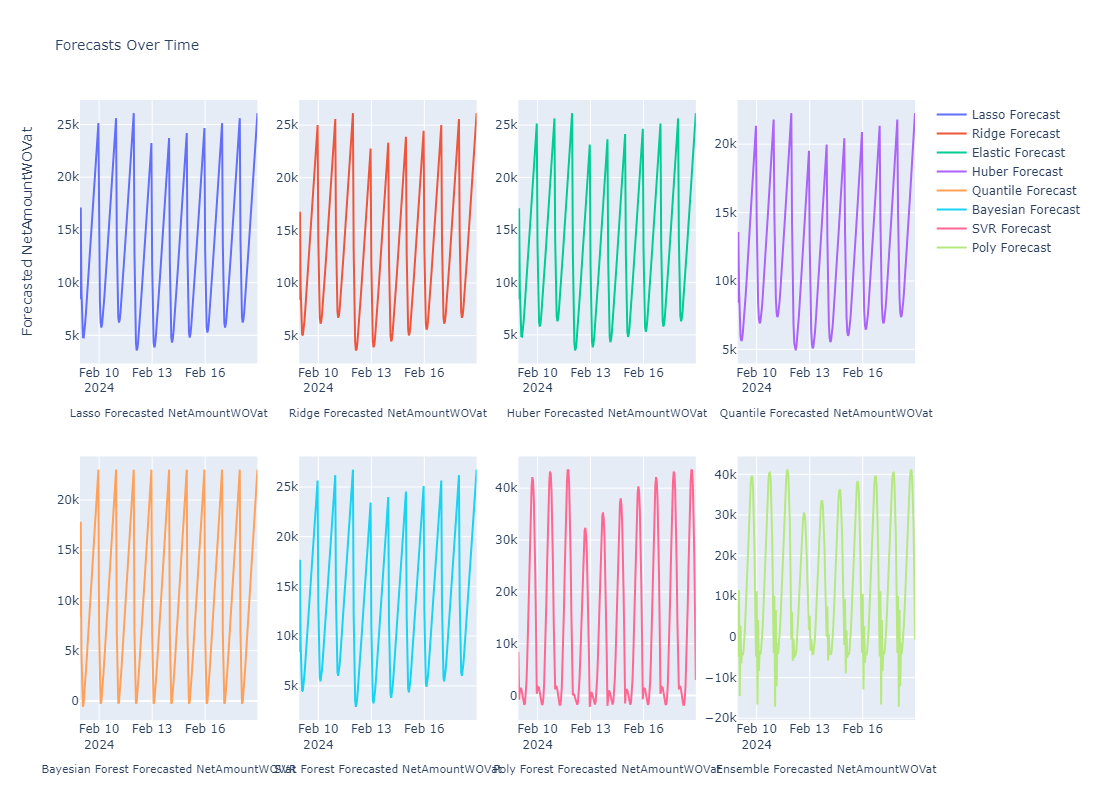

In [50]:
import plotly.subplots as sp
import plotly.graph_objects as go

fig = sp.make_subplots(rows=2, cols=4)

# Lasso
fig.add_trace(go.Scatter(x=lasso_forecast_df_denorm.index, y=lasso_forecast_df_denorm[f'Forecasted {desired_column}'], mode='lines', name='Lasso Forecast'), row=1, col=1)

# Ridge
fig.add_trace(go.Scatter(x=ridge_forecast_df_denorm.index, y=ridge_forecast_df_denorm[f'Forecasted {desired_column}'], mode='lines', name='Ridge Forecast'), row=1, col=2)

# Elastic
fig.add_trace(go.Scatter(x=elastic_forecast_df_denorm.index, y=elastic_forecast_df_denorm[f'Forecasted {desired_column}'], mode='lines', name='Elastic Forecast'), row=1, col=3)

# Huber
fig.add_trace(go.Scatter(x=huber_forecast_df_denorm.index, y=huber_forecast_df_denorm[f'Forecasted {desired_column}'], mode='lines', name='Huber Forecast'), row=1, col=4)

# Quantile
fig.add_trace(go.Scatter(x=quantile_forecast_df_denorm.index, y=quantile_forecast_df_denorm[f'Forecasted {desired_column}'], mode='lines', name='Quantile Forecast'), row=2, col=1)

# Bayesian
fig.add_trace(go.Scatter(x=bayesian_forecast_df_denorm.index, y=bayesian_forecast_df_denorm[f'Forecasted {desired_column}'], mode='lines', name='Bayesian Forecast'), row=2, col=2)

# SVR
fig.add_trace(go.Scatter(x=svr_forecast_df_denorm.index, y=svr_forecast_df_denorm[f'Forecasted {desired_column}'], mode='lines', name='SVR Forecast'), row=2, col=3)

# Poly
fig.add_trace(go.Scatter(x=poly_forecast_df_denorm.index, y=poly_forecast_df_denorm[f'Forecasted {desired_column}'], mode='lines', name='Poly Forecast'), row=2, col=4)

fig.update_layout(title=f'Forecasts Over Time',
                  xaxis_title='Time',
                  yaxis_title=f'Forecasted {desired_column}',
                  width=1200,
                  height=800,
                  showlegend=True, title_font=dict(size=14))

sub_title_size = 11
fig.update_xaxes(title_text=f'Lasso Forecasted {desired_column}', row=1, col=1, title_font=dict(size=sub_title_size))
fig.update_xaxes(title_text=f'Ridge Forecasted {desired_column}', row=1, col=2, title_font=dict(size=sub_title_size))
fig.update_xaxes(title_text=f'Huber Forecasted {desired_column}', row=1, col=3, title_font=dict(size=sub_title_size))
fig.update_xaxes(title_text=f'Quantile Forecasted {desired_column}', row=1, col=4, title_font=dict(size=sub_title_size))
fig.update_xaxes(title_text=f'Bayesian Forest Forecasted {desired_column}', row=2, col=1, title_font=dict(size=sub_title_size))
fig.update_xaxes(title_text=f'SVR Forest Forecasted {desired_column}', row=2, col=2, title_font=dict(size=sub_title_size))
fig.update_xaxes(title_text=f'Poly Forest Forecasted {desired_column}', row=2, col=3, title_font=dict(size=sub_title_size))
fig.update_xaxes(title_text=f'Ensemble Forecasted {desired_column}', row=2, col=4, title_font=dict(size=sub_title_size))

fig.show()

## Table Inference

In [51]:
predictions_by_day_lasso = lasso_forecast_df_denorm.groupby(pd.Grouper(freq='D')).sum()  
predictions_by_day_lasso = predictions_by_day_lasso[[f"Forecasted {desired_column}"]].add_suffix('_Lasso')

predictions_by_day_ridge = ridge_forecast_df_denorm.groupby(pd.Grouper(freq='D')).sum() 
predictions_by_day_ridge = predictions_by_day_ridge[[f"Forecasted {desired_column}"]].add_suffix('_Ridge')

predictions_by_day_elastic = elastic_forecast_df_denorm.groupby(pd.Grouper(freq='D')).sum()
predictions_by_day_elastic = predictions_by_day_elastic[[f"Forecasted {desired_column}"]].add_suffix('_LGB')

predictions_by_day_huber = huber_forecast_df_denorm.groupby(pd.Grouper(freq='D')).sum()  
predictions_by_day_huber = predictions_by_day_huber[[f"Forecasted {desired_column}"]].add_suffix('_Huber')

predictions_by_day_quantile = quantile_forecast_df_denorm.groupby(pd.Grouper(freq='D')).sum()  
predictions_by_day_quantile = predictions_by_day_quantile[[f"Forecasted {desired_column}"]].add_suffix('_Quantile')

predictions_by_day_bayesian = bayesian_forecast_df_denorm.groupby(pd.Grouper(freq='D')).sum()  
predictions_by_day_bayesian = predictions_by_day_bayesian[[f"Forecasted {desired_column}"]].add_suffix('_Bayesian')

predictions_by_day_svr = svr_forecast_df_denorm.groupby(pd.Grouper(freq='D')).sum()  
predictions_by_day_svr = predictions_by_day_svr[[f"Forecasted {desired_column}"]].add_suffix('_SVR')

predictions_by_day_poly = poly_forecast_df_denorm.groupby(pd.Grouper(freq='D')).sum()  
predictions_by_day_poly = predictions_by_day_poly[[f"Forecasted {desired_column}"]].add_suffix('_Poly')

In [52]:
daily_predictions_df = pd.concat([predictions_by_day_lasso, predictions_by_day_ridge, predictions_by_day_elastic,
                                  predictions_by_day_huber, predictions_by_day_quantile, predictions_by_day_bayesian,
                                  predictions_by_day_svr, predictions_by_day_poly], axis=1)

daily_predictions_df

Forecasted NetAmountWOVat_Lasso  Forecasted NetAmountWOVat_Ridge  \
2024-02-08                     25525.008209                     25183.010973   
2024-02-09                    325094.575810                    326322.413756   
2024-02-10                    343872.122925                    347852.110025   
2024-02-11                    355187.122266                    361296.140149   
2024-02-12                    290561.561740                    284759.464934   
2024-02-13                    298612.127682                    294075.994403   
2024-02-14                    309927.126462                    307520.023191   
2024-02-15                    321242.125413                    320964.052431   
2024-02-16                    332557.124364                    334408.081670   
2024-02-17                    343872.123315                    347852.110910   
2024-02-18                    355187.122266                    361296.140149   

            Forecasted NetAmountWOVat_LGB  Forecasted NetAmountWOVat_Huber  \
2024-02-08                   25485.281569                     21987.777304   
2024-02-09                  325558.200921                    288646.429103   
2024-02-10                  345041.985586                    312183.356518   
2024-02-11                  356976.242413                    323163.698822   
2024-02-12                  288842.750932                    262778.322345   
2024-02-13                  297304.960663                    268263.105127   
2024-02-14                  309239.216852                    279243.151895   
2024-02-15                  321173.473242                    290223.288626   
2024-02-16                  333107.729633                    301203.425359   
2024-02-17                  345041.986023                    312183.562093   
2024-02-18                  356976.242413                    323163.698826   

            Forecasted NetAmountWOVat_Quantile  \
2024-02-08                        26251.763391   
2024-02-09                       239181.230125   
2024-02-10                       242443.083747   
2024-02-11                       242443.083748   
2024-02-12                       242443.083747   
2024-02-13                       242443.083747   
2024-02-14                       242443.083747   
2024-02-15                       242443.083747   
2024-02-16                       242443.083748   
2024-02-17                       242443.083748   
2024-02-18                       242443.083748   

            Forecasted NetAmountWOVat_Bayesian  Forecasted NetAmountWOVat_SVR  \
2024-02-08                        26107.723871                    7632.416568   
2024-02-09                       327696.086112                  363153.196721   
2024-02-10                       347609.215118                  373278.981461   
2024-02-11                       360835.623376                  376719.600349   
2024-02-12                       284965.622105                  274834.534053   
2024-02-13                       294703.582725                  302229.833766   
2024-02-14                       307929.990807                  326674.744027   
2024-02-15                       321156.398949                  347291.333832   
2024-02-16                       334382.807092                  363153.345160   
2024-02-17                       347609.215234                  373278.981461   
2024-02-18                       360835.623376                  376719.600349   

            Forecasted NetAmountWOVat_Poly  
2024-02-08                     3539.606339  
2024-02-09                   341573.030287  
2024-02-10                   354683.548500  
2024-02-11                   374580.705839  
2024-02-12                   274700.736272  
2024-02-13                   301244.118619  
2024-02-14                   320215.721870  
2024-02-15                   332463.467814  
2024-02-16                   342190.631056  
2024-02-17                   354683.548500  
2024-02-18                   374580.705839

# PHASE 6: Explainable AI

## Classic

In [53]:
# Lasso Regression
lasso_coeffs = lasso_model.coef_
lasso_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lasso_coeffs})
lasso_feature_importance['Absolute Coefficient'] = np.abs(lasso_feature_importance['Coefficient'])
lasso_feature_importance = lasso_feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
print("Lasso Regression:")
print(lasso_feature_importance)
print("")

# Ridge Regression
ridge_coeffs = ridge_model.coef_
ridge_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': ridge_coeffs})
ridge_feature_importance['Absolute Coefficient'] = np.abs(ridge_feature_importance['Coefficient'])
ridge_feature_importance = ridge_feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
print("Ridge Regression:")
print(ridge_feature_importance)
print("")

# Elastic Net Regression
elasticnet_coeffs = elastic_model.coef_
elasticnet_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': elasticnet_coeffs})
elasticnet_feature_importance['Absolute Coefficient'] = np.abs(elasticnet_feature_importance['Coefficient'])
elasticnet_feature_importance = elasticnet_feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
print("Elastic Net Regression:")
print(elasticnet_feature_importance)
print("")

# Huber Regression
huber_coeffs = huber_model.coef_
huber_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': huber_coeffs})
huber_feature_importance['Absolute Coefficient'] = np.abs(huber_feature_importance['Coefficient'])
huber_feature_importance = huber_feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
print("Huber Regression:")
print(huber_feature_importance)
print("")

# Quantile Regression
quantile_coeffs = quantile_model.coef_
quantile_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': quantile_coeffs})
quantile_feature_importance['Absolute Coefficient'] = np.abs(quantile_feature_importance['Coefficient'])
quantile_feature_importance = quantile_feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
print("Quantile Regression:")
print(quantile_feature_importance)
print("")

# Bayesian Regression
bayesian_coeffs = bayesian_model.coef_
bayesian_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': bayesian_coeffs})
bayesian_feature_importance['Absolute Coefficient'] = np.abs(bayesian_feature_importance['Coefficient'])
bayesian_feature_importance = bayesian_feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
print("Bayesian Regression:")
print(bayesian_feature_importance)
print("")

# SVR Regression
""" SVR için bu tip bir yol bulamadım """

# Poly Regression
poly_model_reg = poly_model.named_steps['linearregression']

poly_coeffs = poly_model_reg.coef_[:len(X_train.columns)]

poly_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': poly_coeffs})
poly_feature_importance['Absolute Coefficient'] = np.abs(poly_feature_importance['Coefficient'])
poly_feature_importance = poly_feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
print("Poly Regression:")
print(poly_feature_importance)
print("")

Lasso Regression:
                   Feature  Coefficient  Absolute Coefficient
2  NetAmountWOVat Before 1     0.497275              0.497275
0             HourInterval     0.030172              0.030172
1                DayOfWeek     0.013289              0.013289

Ridge Regression:
                   Feature  Coefficient  Absolute Coefficient
2  NetAmountWOVat Before 1     0.512817              0.512817
0             HourInterval     0.028898              0.028898
1                DayOfWeek     0.015301              0.015301

Elastic Net Regression:
                   Feature  Coefficient  Absolute Coefficient
2  NetAmountWOVat Before 1     0.499369              0.499369
0             HourInterval     0.030033              0.030033
1                DayOfWeek     0.013958              0.013958

Huber Regression:
                   Feature  Coefficient  Absolute Coefficient
2  NetAmountWOVat Before 1     0.631810              0.631810
0             HourInterval     0.018496            

## SHAP

In [54]:
import shap

In [55]:
# Lasso
explainer_lasso = shap.LinearExplainer(lasso_model, X_train)
shap_values_lasso_valid = explainer_lasso.shap_values(X_valid)
shap_values_lasso_train = explainer_lasso.shap_values(X_train)

df_shap_lasso_valid = pd.DataFrame(shap_values_lasso_valid, columns=X_valid.columns.values)
df_shap_lasso_train = pd.DataFrame(shap_values_lasso_train, columns=X_train.columns.values)

# Ridge
explainer_ridge = shap.LinearExplainer(ridge_model, X_train)
shap_values_ridge_valid = explainer_ridge.shap_values(X_valid)
shap_values_ridge_train = explainer_ridge.shap_values(X_train)

df_shap_ridge_valid = pd.DataFrame(shap_values_ridge_valid, columns=X_valid.columns.values)
df_shap_ridge_train = pd.DataFrame(shap_values_ridge_train, columns=X_train.columns.values)

# Elastic
explainer_elastic = shap.LinearExplainer(elastic_model, X_train)
shap_values_elastic_valid = explainer_elastic.shap_values(X_valid)
shap_values_elastic_train = explainer_elastic.shap_values(X_train)

df_shap_elastic_valid = pd.DataFrame(shap_values_elastic_valid, columns=X_valid.columns.values)
df_shap_elastic_train = pd.DataFrame(shap_values_elastic_train, columns=X_train.columns.values)

# Huber
explainer_huber = shap.LinearExplainer(huber_model, X_train)
shap_values_huber_valid = explainer_huber.shap_values(X_valid)
shap_values_huber_train = explainer_huber.shap_values(X_train)

df_shap_huber_valid = pd.DataFrame(shap_values_huber_valid, columns=X_valid.columns.values)
df_shap_huber_train = pd.DataFrame(shap_values_huber_train, columns=X_train.columns.values)

# Quantile 
explainer_quantile = shap.LinearExplainer(quantile_model, X_train)
shap_values_quantile_valid = explainer_quantile.shap_values(X_valid)
shap_values_quantile_train = explainer_quantile.shap_values(X_train)

df_shap_quantile_valid = pd.DataFrame(shap_values_quantile_valid, columns=X_valid.columns.values)
df_shap_quantile_train = pd.DataFrame(shap_values_quantile_train, columns=X_train.columns.values)

# Bayesian Ridge 
explainer_bayesian = shap.LinearExplainer(bayesian_model, X_train)
shap_values_bayesian_valid = explainer_bayesian.shap_values(X_valid)
shap_values_bayesian_train = explainer_bayesian.shap_values(X_train)

df_shap_bayesian_valid = pd.DataFrame(shap_values_bayesian_valid, columns=X_valid.columns.values)
df_shap_bayesian_train = pd.DataFrame(shap_values_bayesian_train, columns=X_train.columns.values)

# SVR 
explainer_svr = shap.KernelExplainer(svr_model.predict, X_train)
shap_values_svr_valid = explainer_svr.shap_values(X_valid)
shap_values_svr_train = explainer_svr.shap_values(X_train)

df_shap_svr_valid = pd.DataFrame(shap_values_svr_valid, columns=X_valid.columns.values)
df_shap_svr_train = pd.DataFrame(shap_values_svr_train, columns=X_train.columns.values)

# Poly Regression 
def poly_predict(data):
    return poly_model.predict(data)

explainer_poly = shap.KernelExplainer(poly_predict, X_train)
shap_values_poly_valid = explainer_poly.shap_values(X_valid)
shap_values_poly_train = explainer_poly.shap_values(X_train)

df_shap_poly_valid = pd.DataFrame(shap_values_poly_valid, columns=X_valid.columns.values)
df_shap_poly_train = pd.DataFrame(shap_values_poly_train, columns=X_train.columns.values)

Using 162 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

Using 162 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

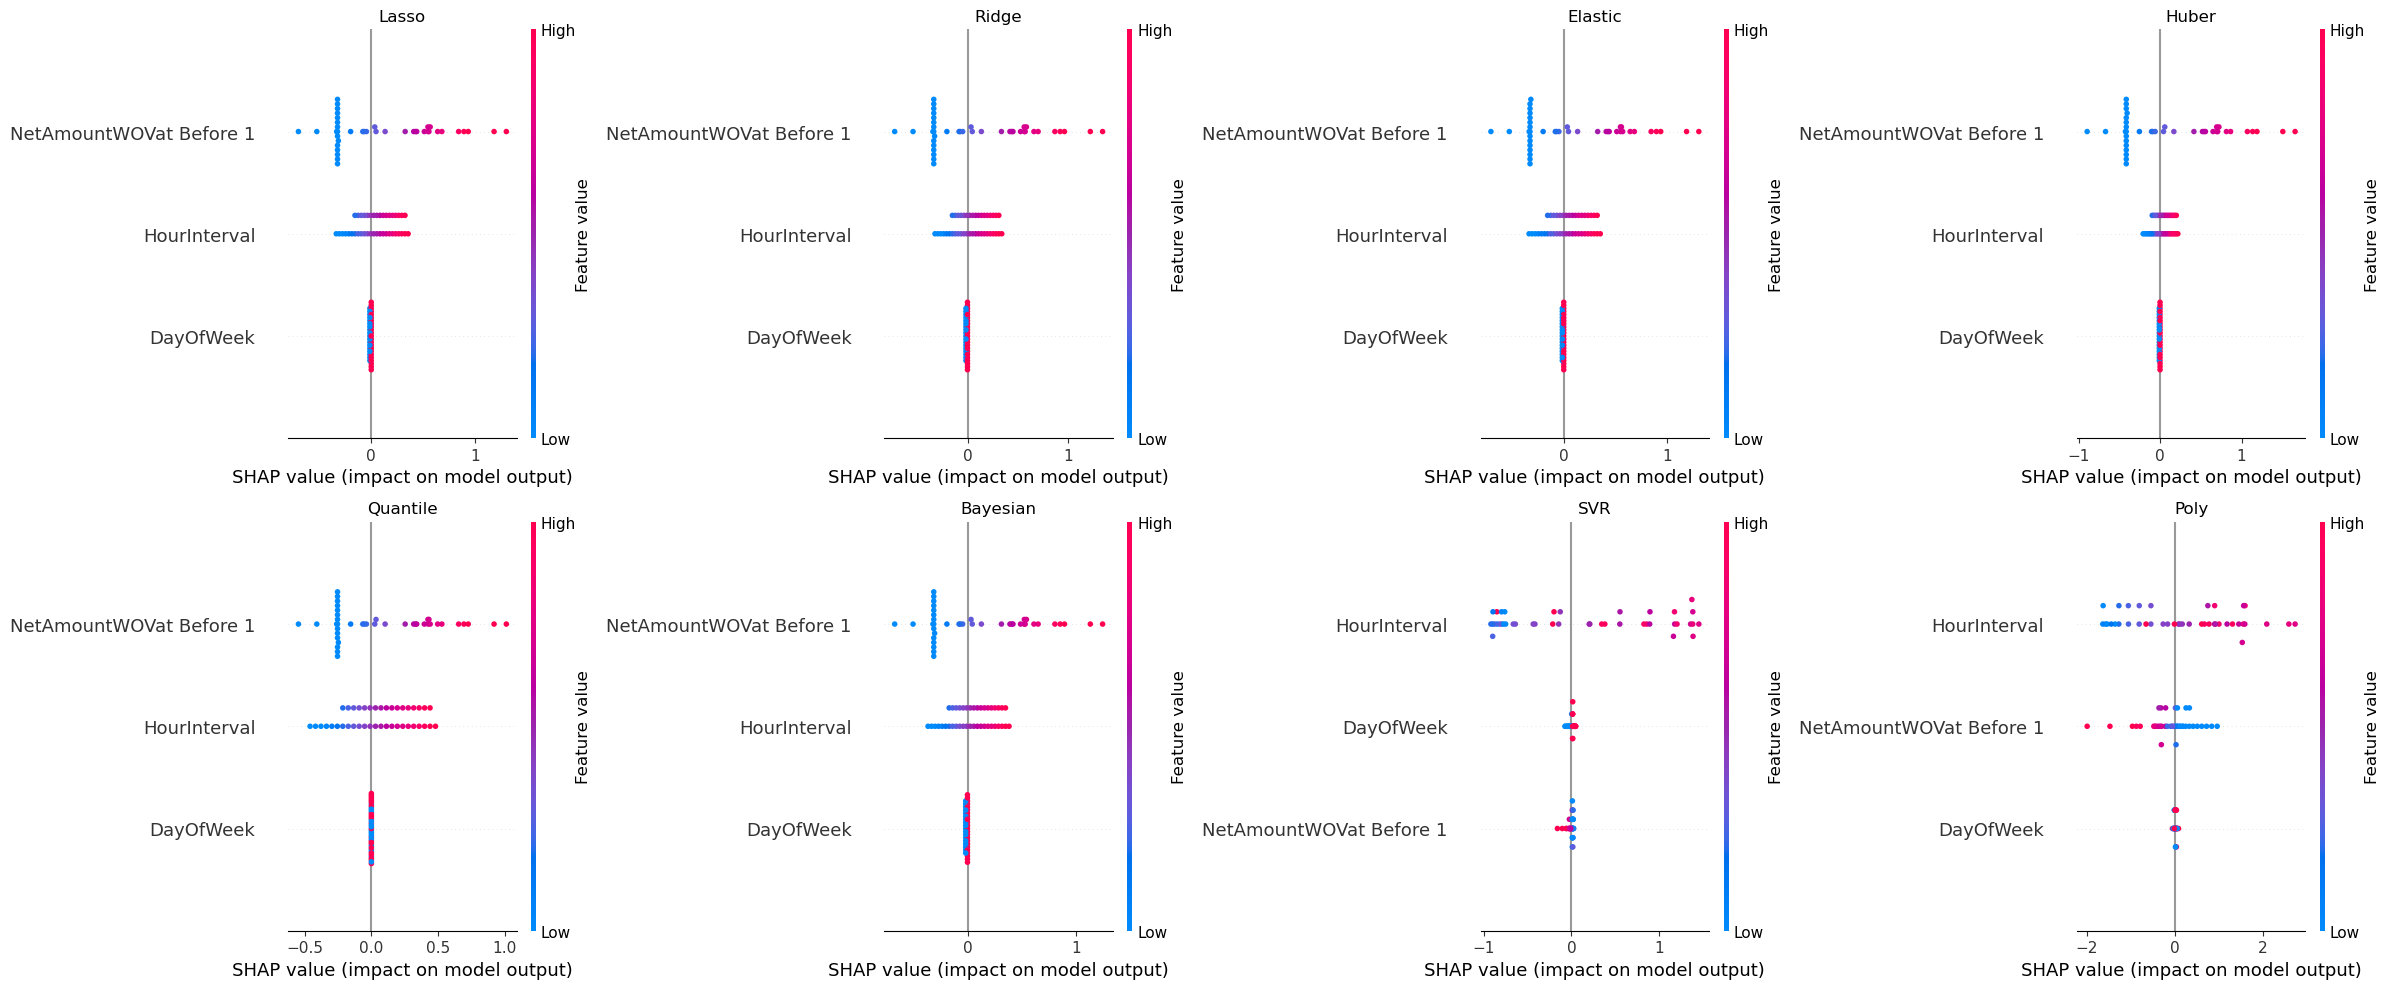

In [56]:
plt.figure(figsize=(24, 10))

# Lasso
plt.subplot(2, 4, 1)
shap.summary_plot(shap_values_lasso_valid, X_valid, plot_size=None, show=False)
plt.title('Lasso')

# Ridge
plt.subplot(2, 4, 2)
shap.summary_plot(shap_values_ridge_valid, X_valid, plot_size=None, show=False)
plt.title('Ridge')

# Elastic
plt.subplot(2, 4, 3)
shap.summary_plot(shap_values_elastic_valid, X_valid, plot_size=None, show=False)
plt.title('Elastic')

# Huber
plt.subplot(2, 4, 4)
shap.summary_plot(shap_values_huber_valid, X_valid, plot_size=None, show=False)
plt.title('Huber')

# Quantile
plt.subplot(2, 4, 5)
shap.summary_plot(shap_values_quantile_valid, X_valid, plot_size=None, show=False)
plt.title('Quantile')

# Bayesian
plt.subplot(2, 4, 6)
shap.summary_plot(shap_values_bayesian_valid, X_valid, plot_size=None, show=False)
plt.title('Bayesian')

# SVR
plt.subplot(2, 4, 7)
shap.summary_plot(shap_values_svr_valid, X_valid, plot_size=None, show=False)
plt.title('SVR')

# Poly
plt.subplot(2, 4, 8)
shap.summary_plot(shap_values_poly_valid, X_valid, plot_size=None, show=False)
plt.title('Poly')

plt.tight_layout()
plt.show()

In [57]:
j = 8
sample = X_valid.iloc[[j]]
print("Features:", sample)
print("Label:", y_valid.iloc[[j]].values * std + mean)
print("")

shap.initjs()

# Lasso
print("Lasso prediction")
print("Denormalized:", int(sum(shap_values_lasso_valid[j]) * std + mean))
display(shap.force_plot(explainer_lasso.expected_value, shap_values_lasso_valid[j], sample))

# Ridge
print("Ridge prediction")
print("Denormalized:", int(sum(shap_values_ridge_valid[j]) * std + mean))
display(shap.force_plot(explainer_ridge.expected_value, shap_values_ridge_valid[j], sample))

# Elastic
print("Elastic prediction")
print("Denormalized:", int(sum(shap_values_elastic_valid[j]) * std + mean))
display(shap.force_plot(explainer_elastic.expected_value, shap_values_elastic_valid[j], sample))

# Huber
print("Huber prediction")
print("Denormalized:", int(sum(shap_values_huber_valid[j]) * std + mean))
display(shap.force_plot(explainer_huber.expected_value, shap_values_huber_valid[j], sample))

# Quantile
print("Quantile prediction")
print("Denormalized:", int(sum(shap_values_quantile_valid[j]) * std + mean))
display(shap.force_plot(explainer_quantile.expected_value, shap_values_quantile_valid[j], sample))

# Bayesian
print("Bayesian prediction")
print("Denormalized:", int(sum(shap_values_bayesian_valid[j]) * std + mean))
display(shap.force_plot(explainer_bayesian.expected_value, shap_values_bayesian_valid[j], sample))

# SVR
print("SVR prediction")
print("Denormalized:", int(sum(shap_values_svr_valid[j]) * std + mean))
display(shap.force_plot(explainer_svr.expected_value, shap_values_svr_valid[j], sample))

# Poly
print("Poly prediction")
print("Denormalized:", int(sum(shap_values_poly_valid[j]) * std + mean))
display(shap.force_plot(explainer_poly.expected_value, shap_values_poly_valid[j], sample))

Features:                      HourInterval  DayOfWeek  NetAmountWOVat Before 1
TransactionDateTime                                                  
2024-02-07 14:00:00            14          3                 -0.01199
Label: [31310.19]



Lasso prediction
Denormalized: 15574


Ridge prediction
Denormalized: 15497


Elastic prediction
Denormalized: 15557


Huber prediction
Denormalized: 15291


Quantile prediction
Denormalized: 16181


Bayesian prediction
Denormalized: 15594


SVR prediction
Denormalized: 29756


Poly prediction
Denormalized: 28575
